In [22]:
#from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
#from thllib import util
import figurefirst as fifi
import scipy.signal
#import local_project_functions as lpf
from IPython.display import SVG,display
import networkx as nx


import flylib as flb
#from thllib import flylib as flb
import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from flylib import util
import figurefirst as fifi
import scipy.signal
#import local_project_functions as lpf
from IPython.display import SVG,display
import pandas as pd
import networkx as nx

In [23]:
from scipy.stats import gaussian_kde

In [2]:
%matplotlib inline

In [3]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]

In [4]:
fly_nums = range(1389,1402)#,1545)
multi_fly_df = util.construct_multi_fly_df(fly_nums)

Making dataframe for fly number 1389
Making dataframe for fly number 1390
Making dataframe for fly number 1391
Making dataframe for fly number 1392
Making dataframe for fly number 1393
Making dataframe for fly number 1394
Making dataframe for fly number 1395
Making dataframe for fly number 1396
Making dataframe for fly number 1397
Making dataframe for fly number 1398
Making dataframe for fly number 1399
Making dataframe for fly number 1400
Making dataframe for fly number 1401


In [5]:
sorted_keys = sorted(fly.spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd')]

for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]

flydict = {}
for fly in flylist:
    flydict[fly.flynum] = fly
    
stim_conditions = [('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0')]

In [6]:
print(multi_fly_df.columns.values)
print(np.unique(multi_fly_df['stimulus']))

idx = (multi_fly_df['stimulus']=='cl_blocks, g_x=-1, g_y=0, b_x=-8, b_y=0, ch=True')& \
        ((multi_fly_df['amp_diff']>0.1)&(multi_fly_df['amp_diff']<0.104))


['t' 'stimulus' 'amp_diff' 'left_amp' 'right_amp' 'fly_num' 'wbf'
 'experimental_condition' 'pr_left' 'tpd_left' 'nm_left' 'iii1_left'
 'iii3_left' 'i2_left' 'hg2_left' 'hg3_left' 'hg1_left' 'i1_left'
 'bkg_left' 'b1_left' 'b2_left' 'b3_left' 'iii24_left' 'hg4_left'
 'pr_right' 'tpd_right' 'nm_right' 'iii1_right' 'iii3_right' 'i2_right'
 'hg2_right' 'hg3_right' 'hg1_right' 'i1_right' 'bkg_right' 'b1_right'
 'b2_right' 'b3_right' 'iii24_right' 'hg4_right']
['cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0'
 'ol_blocks, g_x=-12, g_y=0 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=-4 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=0 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'
 '

In [7]:
muscle_key_list = ('Lb1', 'Lb2', 'Lb3', 'Li1', 'Li2', 'Liii1', 'Liii3',  'Lhg1', 'Lhg2', 'Lhg3', 'Lhg4', 
                   'Rb1', 'Rb2', 'Rb3', 'Ri1', 'Ri2', 'Riii1', 'Riii3',  'Rhg1', 'Rhg2', 'Rhg3', 'Rhg4') 

In [8]:
fly.non_neg_signals['right', 'hg2']

array([ 0.19662173,  0.19662173,  0.19662173, ...,  0.        ,
        0.        ,  0.        ])

In [9]:
def key_to_key(inkey):
    """map the input key from the cov_mtrx_triang_layout.svg into a set of keys 
    (a tuple of tuples) that can be used to construct signals from the fly data"""
    try:
        k1 = {'R':'right','L':'left'}[inkey[0]]
    except KeyError:
        if inkey[0] == 'w':
            return ('common','wb_freq')
        else:
            return
    k2 = inkey[1:]
    return (k1,k2)

In [67]:
def make_scatter_plots(fly):
    """create summary plot for each fly in flylist, uses the template 
    file cov_matrix_triang_layout.svg, the hdf5 data of each fly needs to 
    be loaded"""
    if 'data_mask' in fly.h5files.keys():
        #fifi.mpl_functions.kill_all_spines(layout)
        dmask = np.array(fly.data_mask)
        
        already_plotted = []

        for key1 in muscle_key_list:
            for key2 in muscle_key_list:
                try:
                    
                    dkeys = (key_to_key(key1),key_to_key(key2))
                    
                    keys = (key1, key2)
                    keys_inverse = (key2, key1)
                    
                    if keys in already_plotted:
                        #do nothing
                        continue
                    if keys_inverse in already_plotted:
                        #do nothing
                        continue
                        
                    else:
                        fig, ax = plt.subplots()                
                        dta1 = fly.non_neg_signals[dkeys[0]]#[::5]#[dmask][::50]
                        dta2 = fly.non_neg_signals[dkeys[1]]#[::5]#[dmask][::50]

                        # Calculate the point density
                        #xy = np.vstack([dta1.ravel(),dta2.ravel()])
                        
                        #kernel = gaussian_kde((xy)(xy))
                        
                        #z=np.reshape(kernel(xy).T, dta1.shape)
                        
                        heatmap, xedges, yedges = np.histogram2d(dta1, dta2, bins=20) #50 or 100
                        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

                        
                        
                        
                        '''
                        ax.scatter(dta1,dta2,
                                   marker = '.',
                                   s = 5,  #0.5
                                   #color = 'black',
                                   color = z,
                                   alpha = 0.5,
                                   edgecolors = 'none',
                                   rasterized = True)
                        '''
                        ax.set_xbound(0,1)
                        ax.set_ybound(0,1)
                        
                        plt.rcParams['image.cmap'] = 'gray'
                        
                        
                        plt.clf()
                        plt.imshow(heatmap.T, extent=extent, origin='lower')


                        plt.show()
                        fig.savefig('%s_%s.jpg' % (key1, key2))

                        already_plotted.append(keys)  
                        already_plotted.append(keys_inverse) 
                        
                        #fifi.mpl_functions.kill_spines(ax)
                except KeyError:
                    if key == 'flynum':
                        ax.text(0,0,'Fly%s'%fly.flynum,size = 20)
                    else:
                        pass
            #layout.save('scatter_matrix_%s.svg'%fly.flynum)
            #plt.close('all')
            
        #display(SVG('scatter_matrix_%s.svg'%fly.flynum))

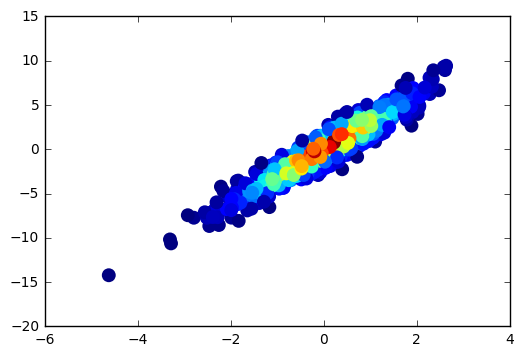

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = np.random.normal(size=1000)
y = x * 3 + np.random.normal(size=1000)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.show()

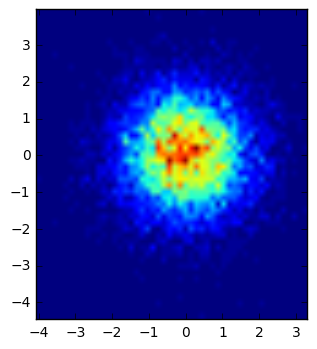

In [56]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
x = np.random.randn(8873)
y = np.random.randn(8873)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [69]:
#outfile = '%s/%s.jpg' % (self.tgtdir, self.basename)

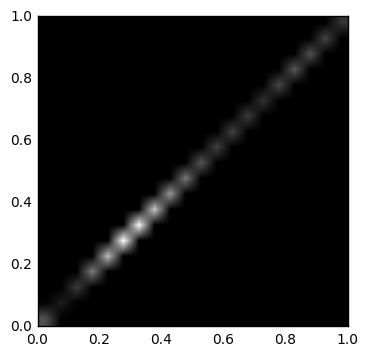

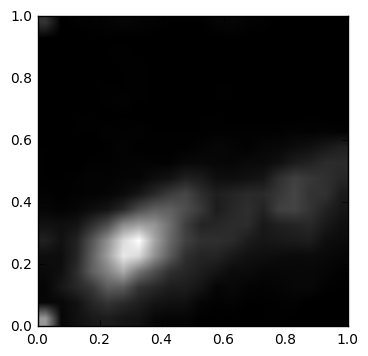

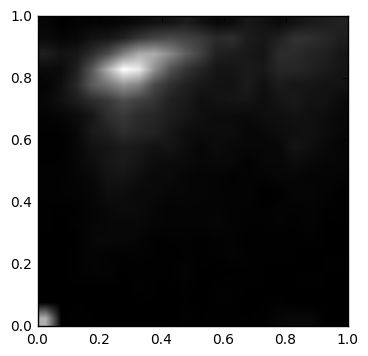

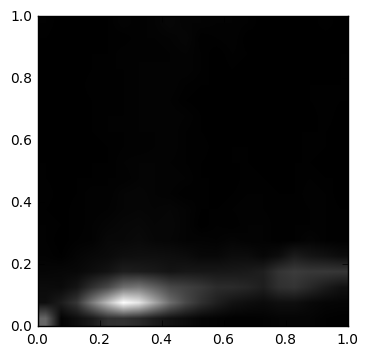

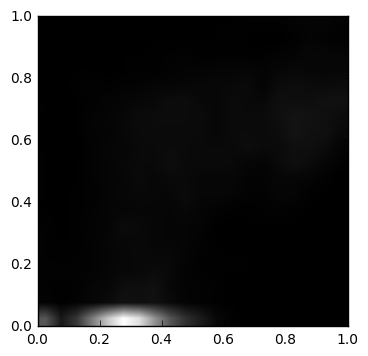

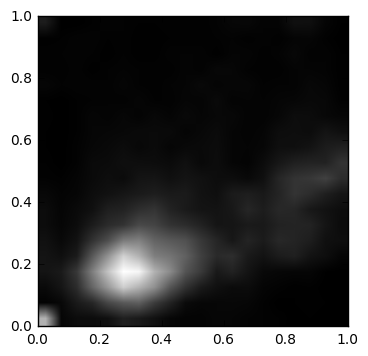

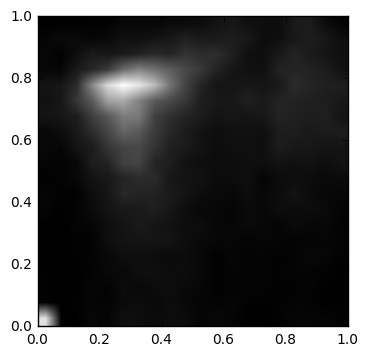

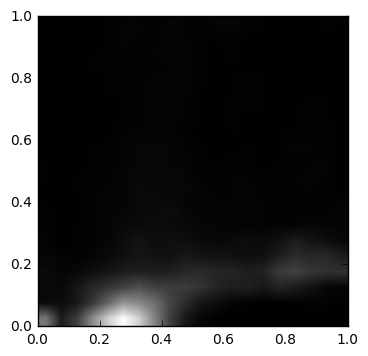

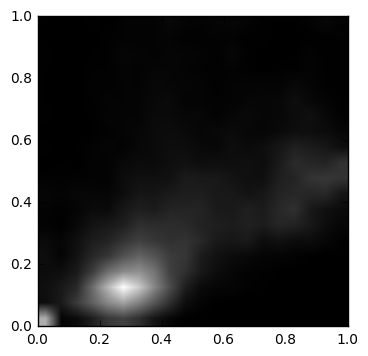

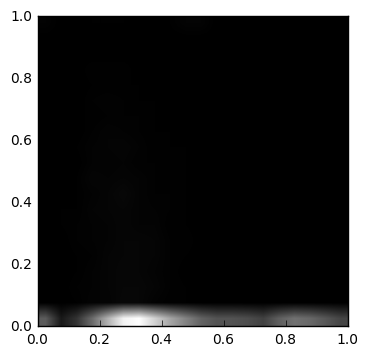

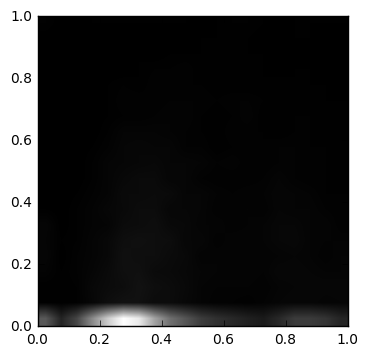

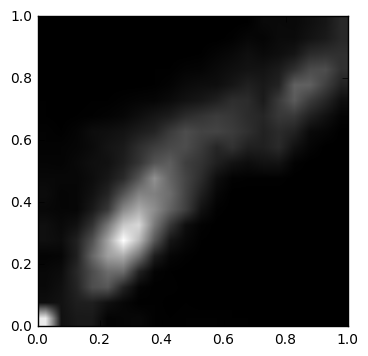

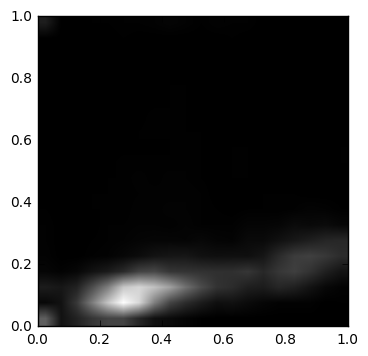

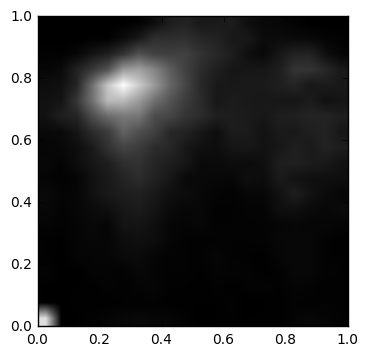

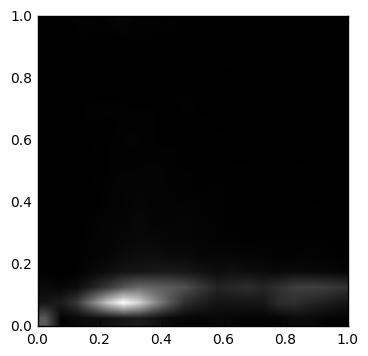

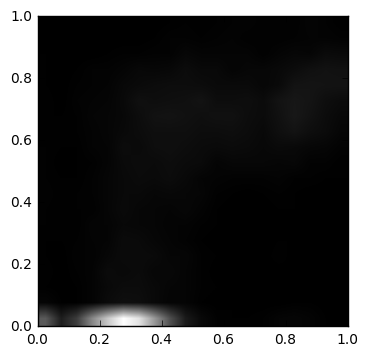

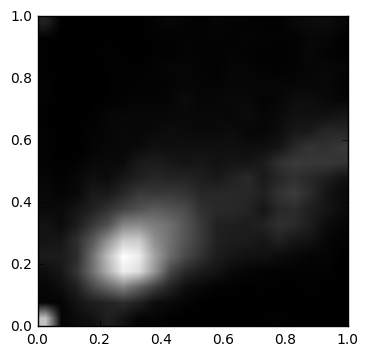

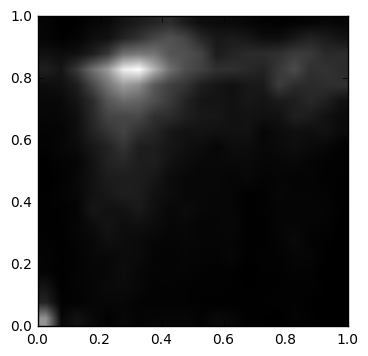

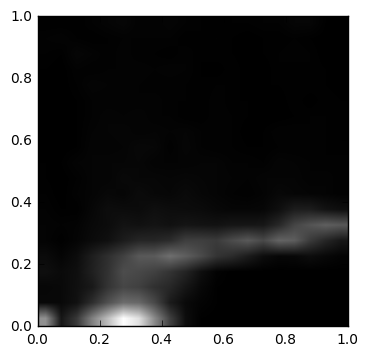

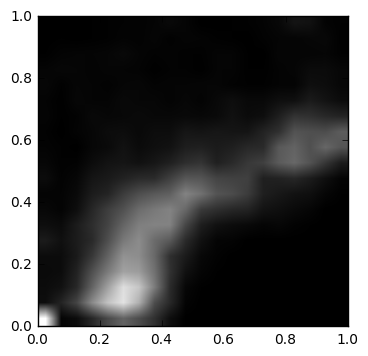

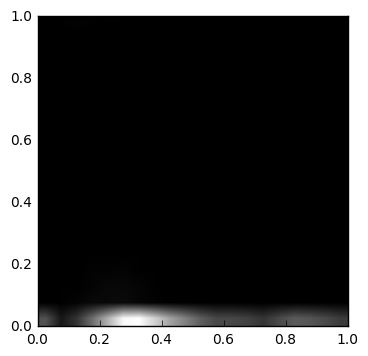

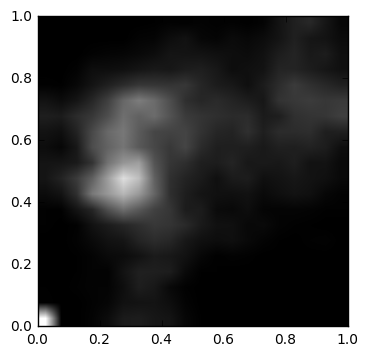

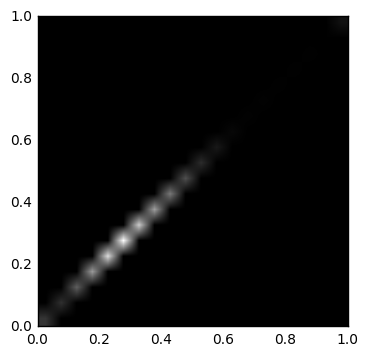

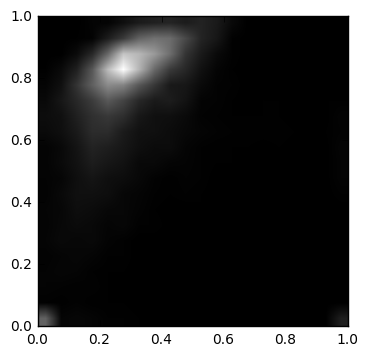

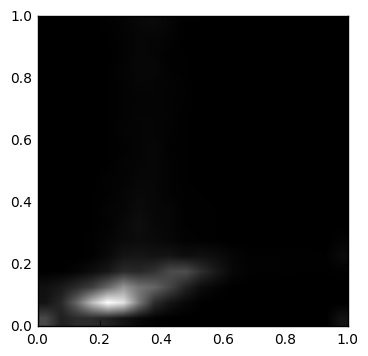

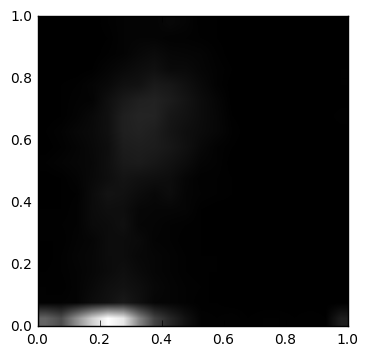

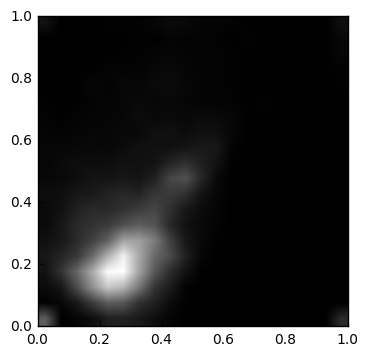

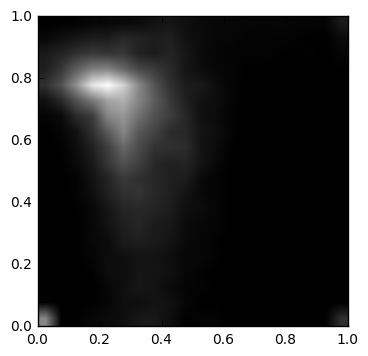

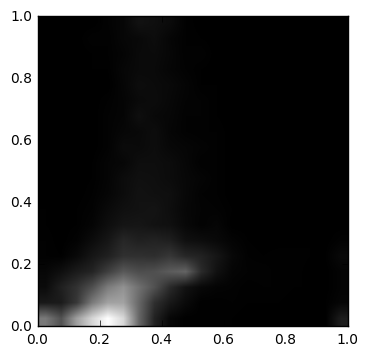

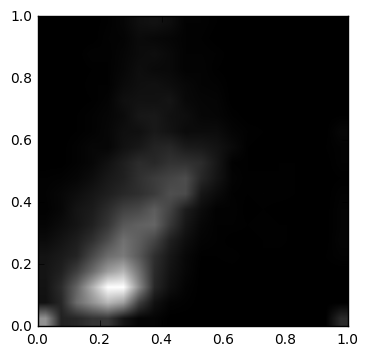

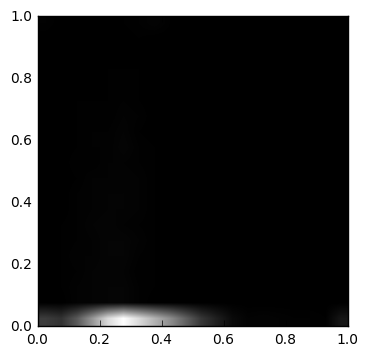

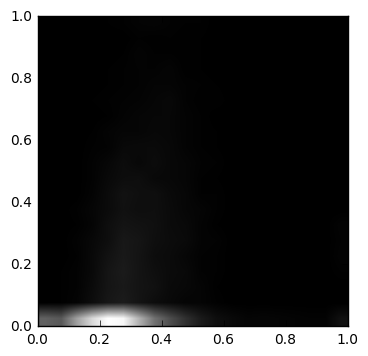

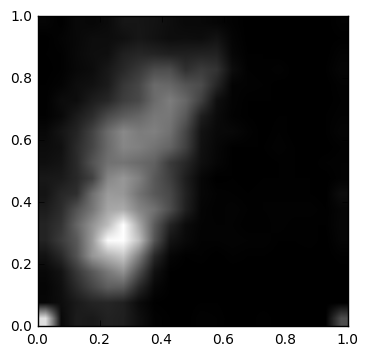

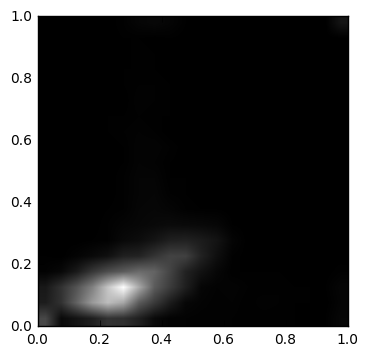

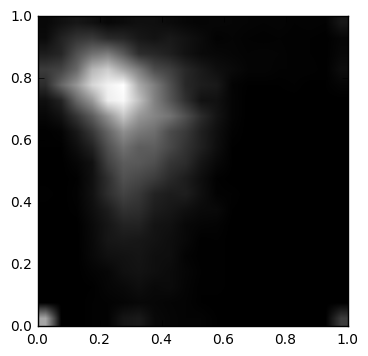

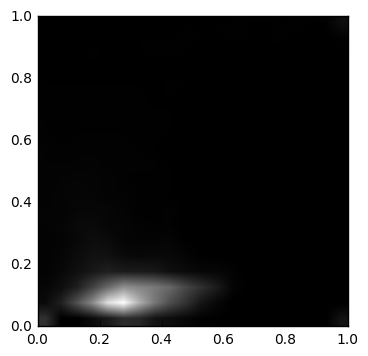

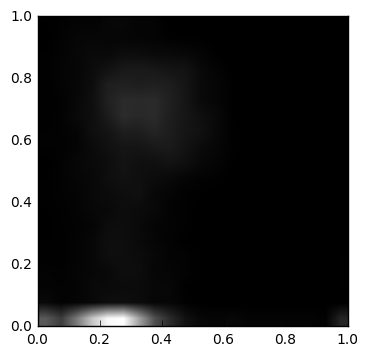

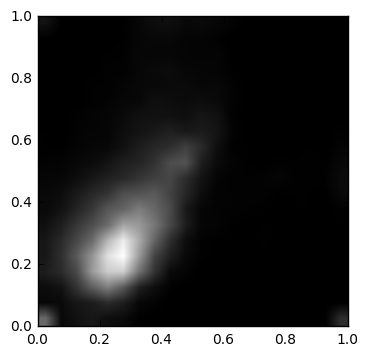

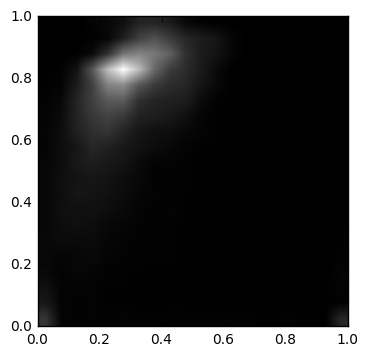

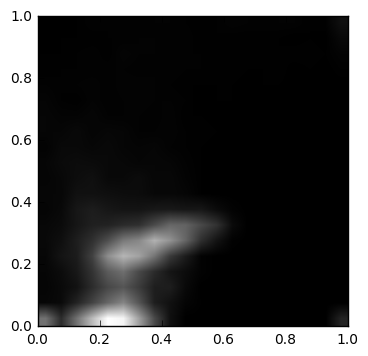

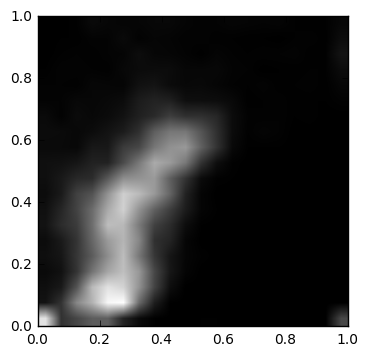

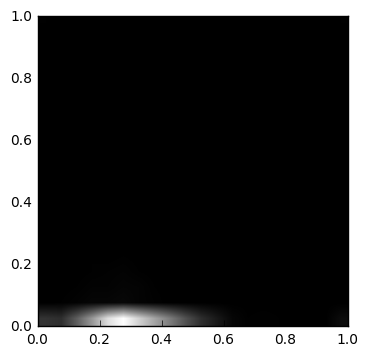

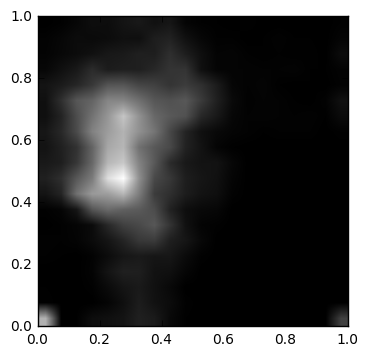

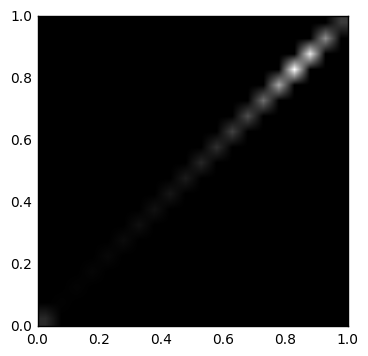

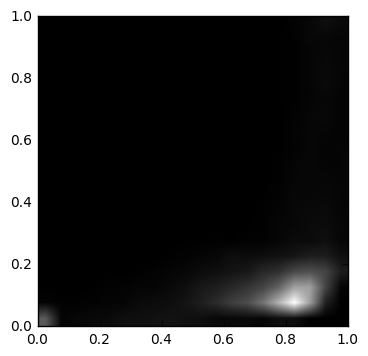

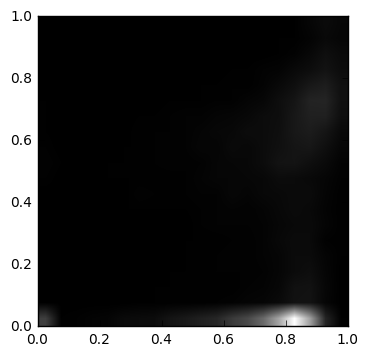

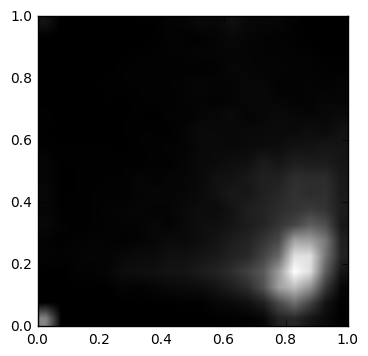

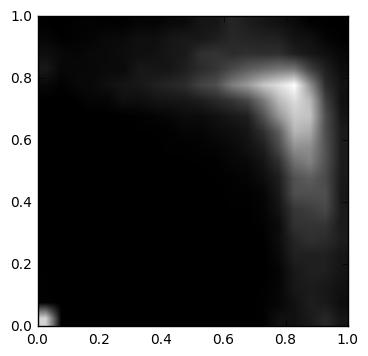

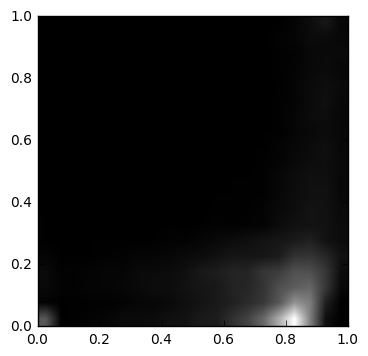

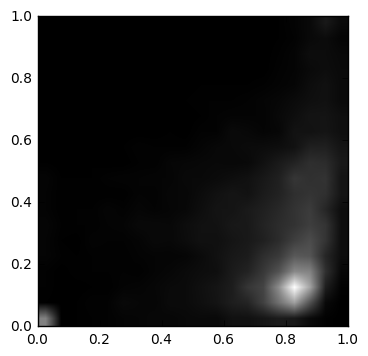

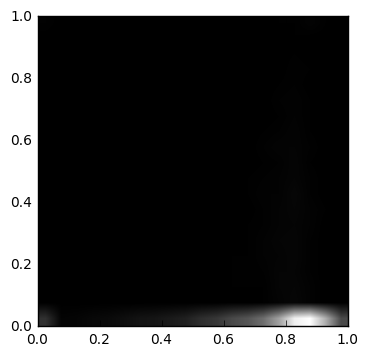

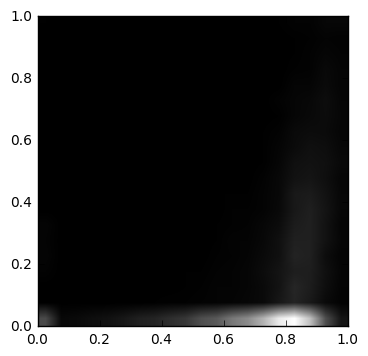

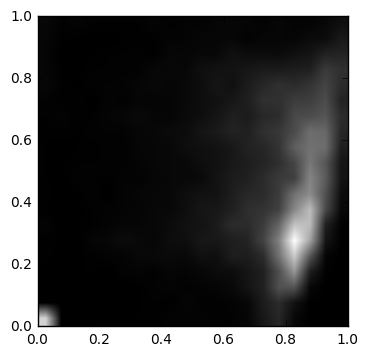

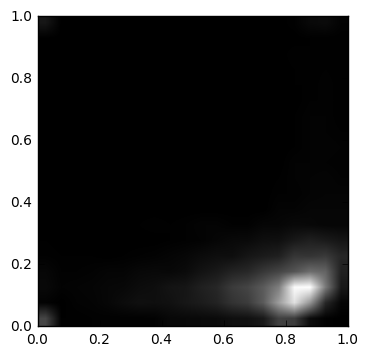

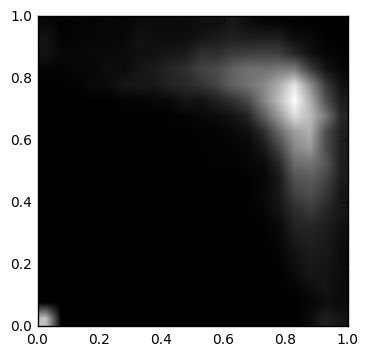

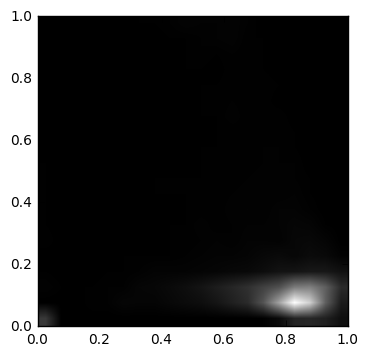

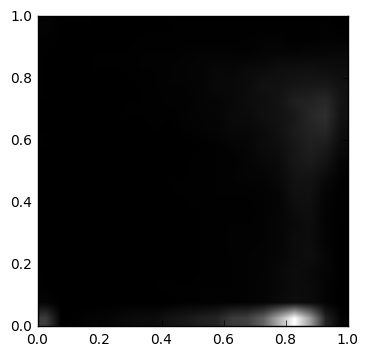

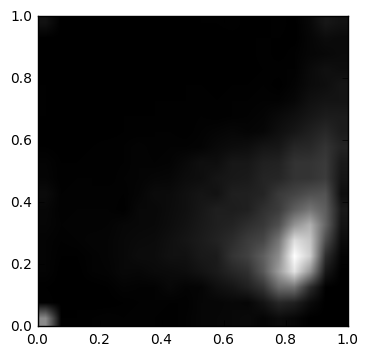

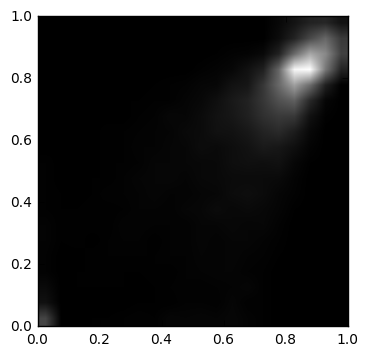

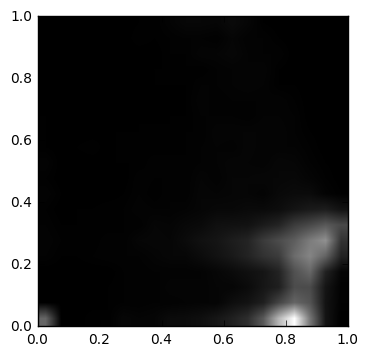

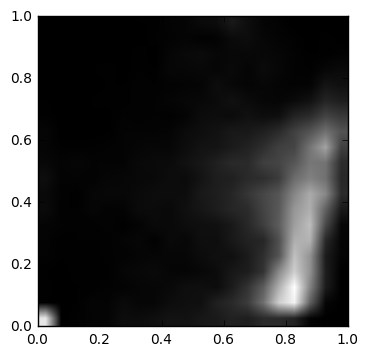

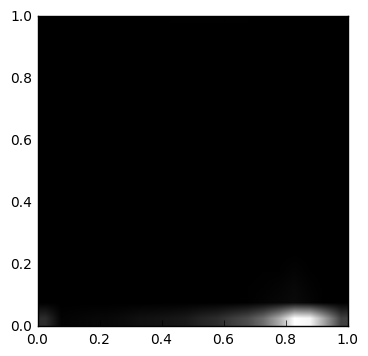

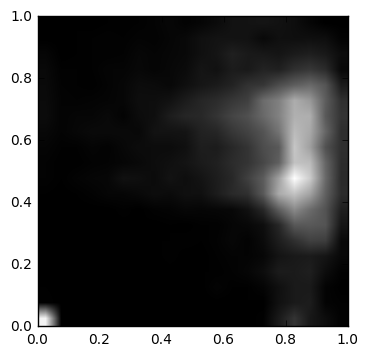

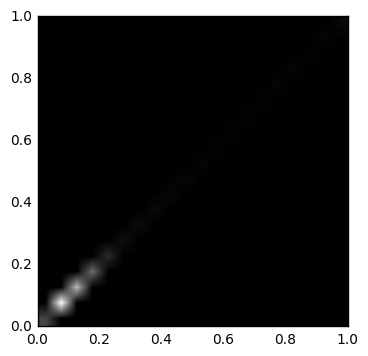

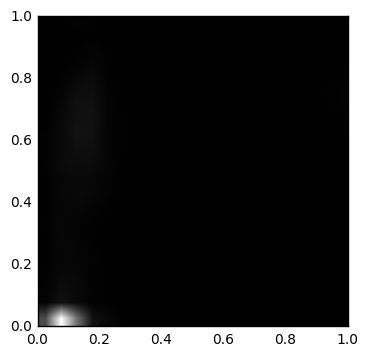

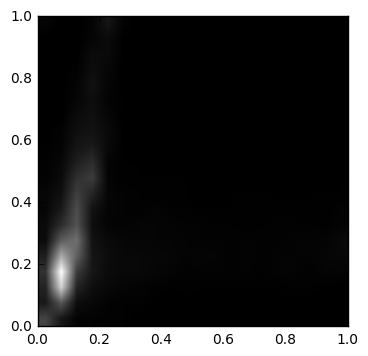

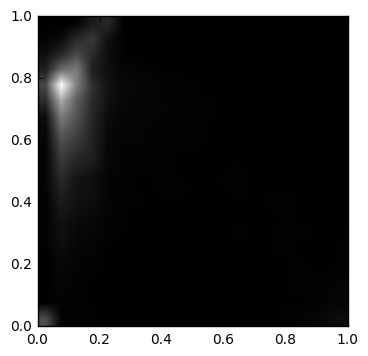

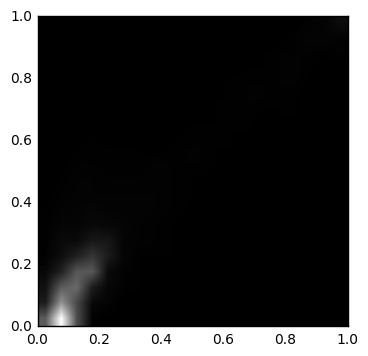

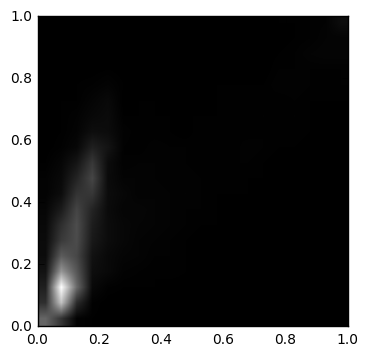

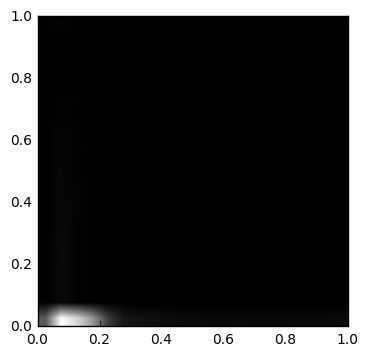

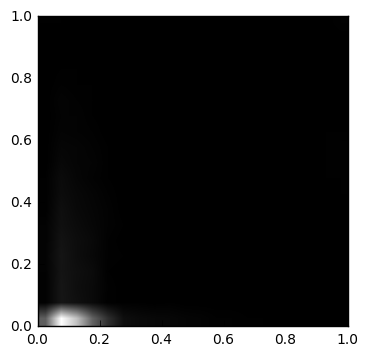

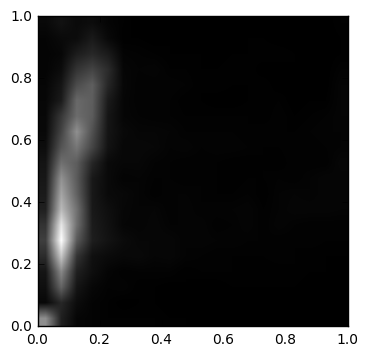

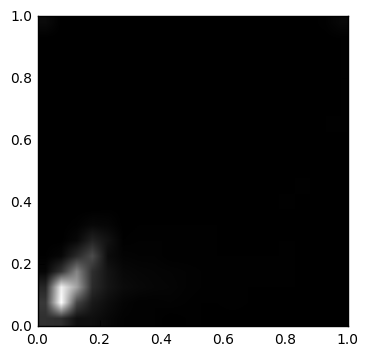

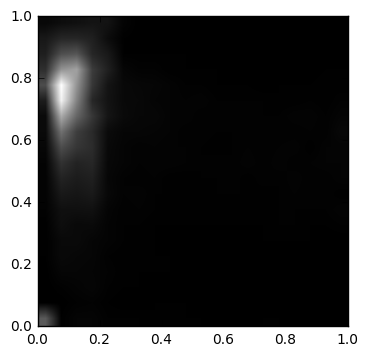

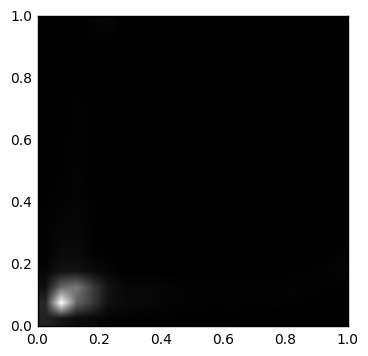

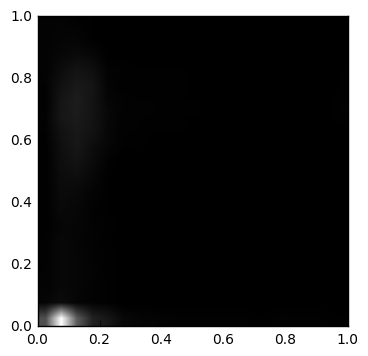

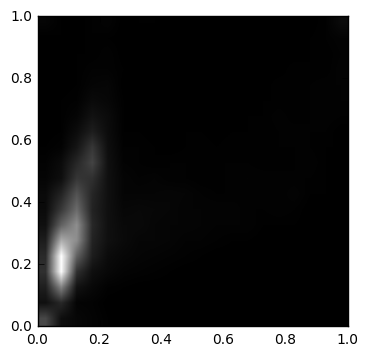

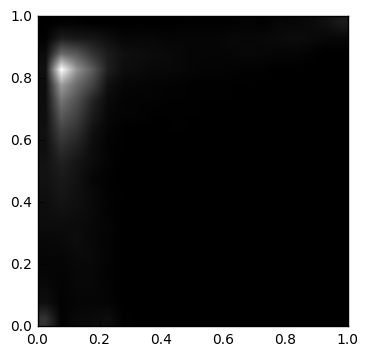

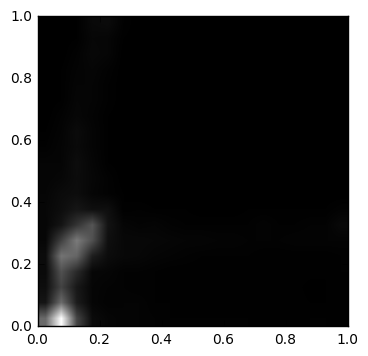

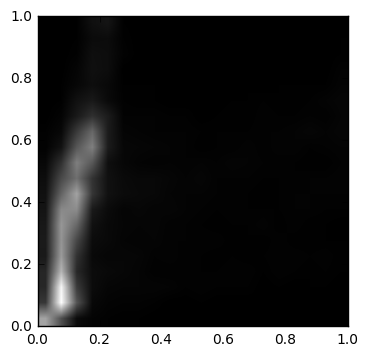

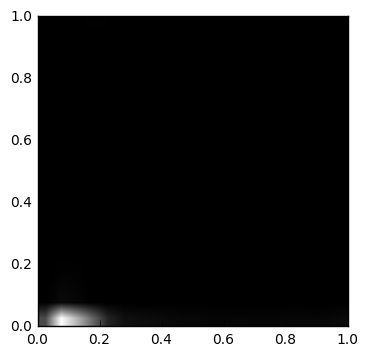

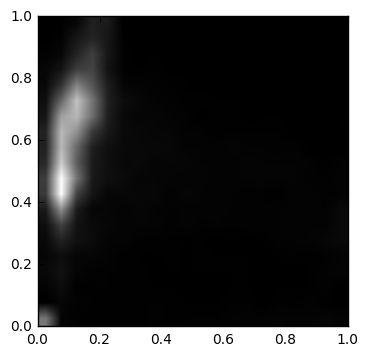

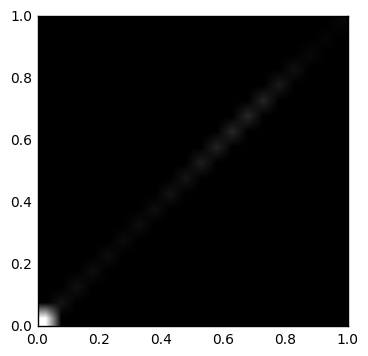

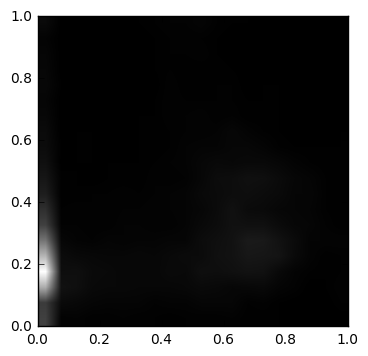

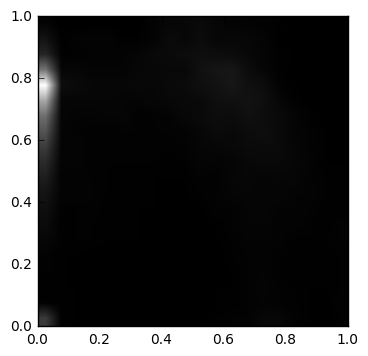

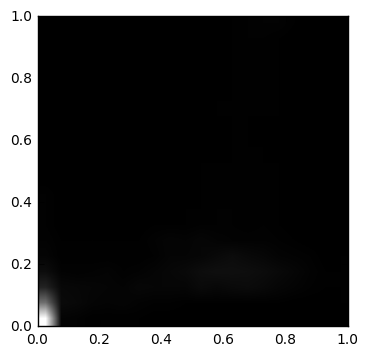

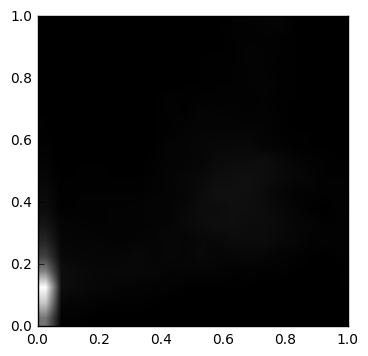

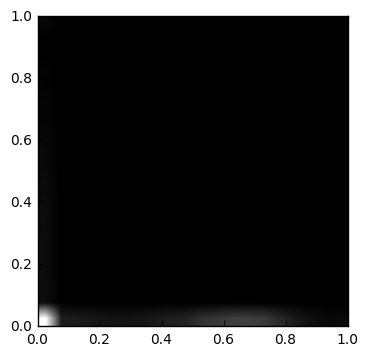

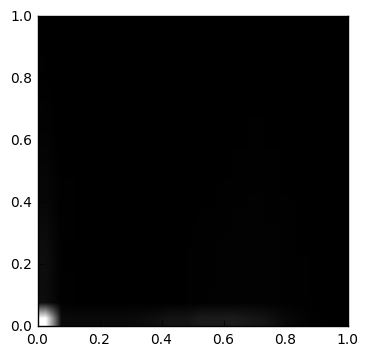

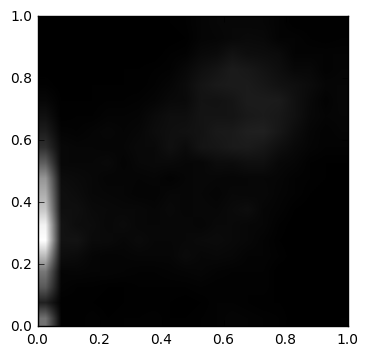

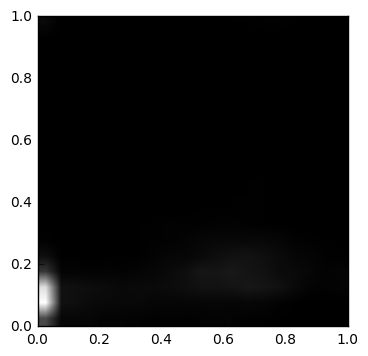

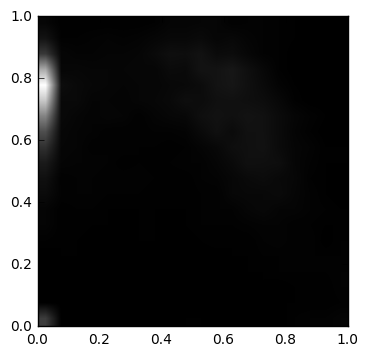

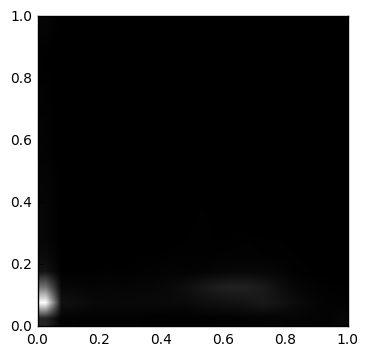

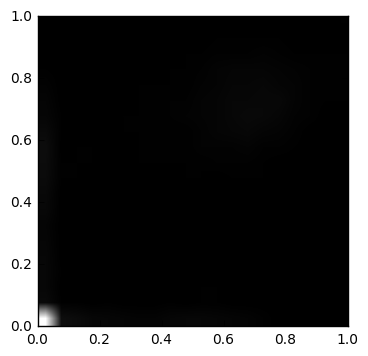

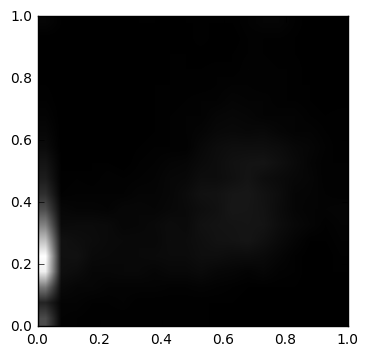

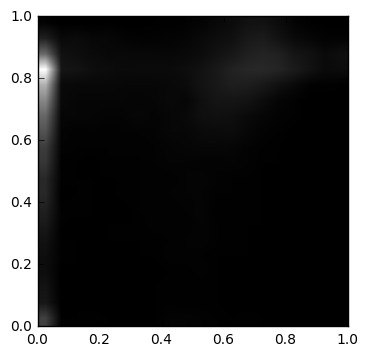

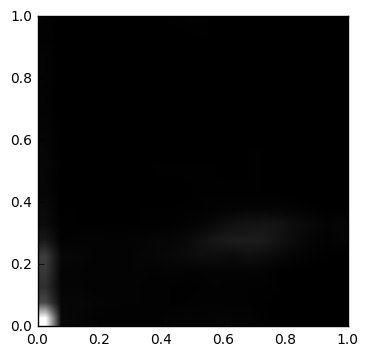

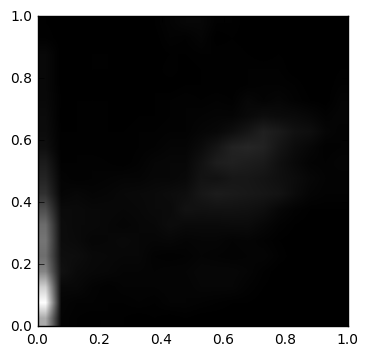

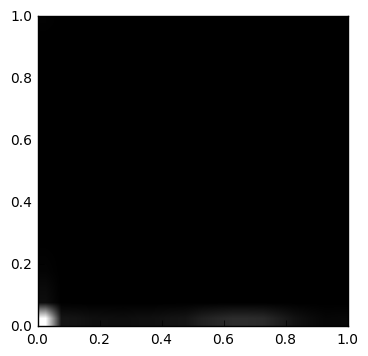

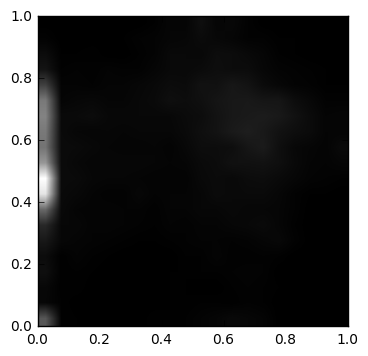

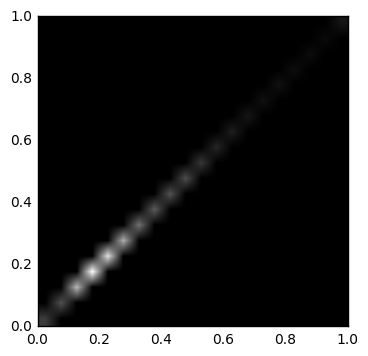

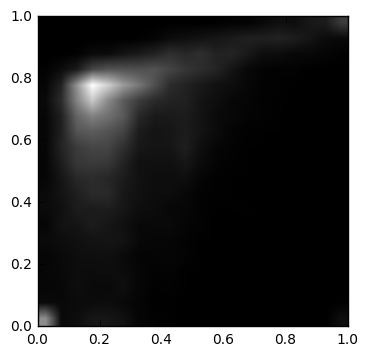

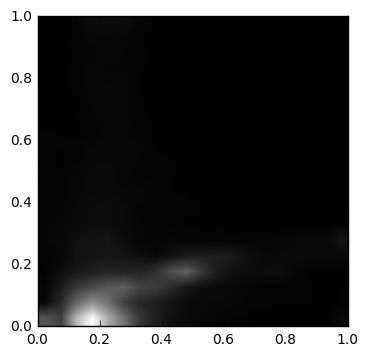

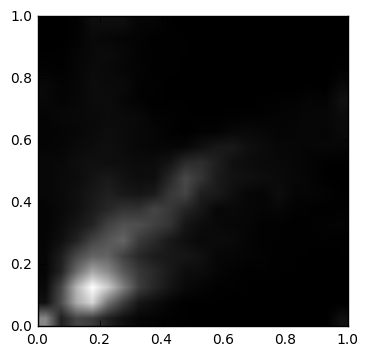

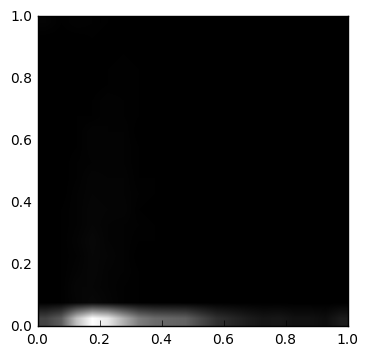

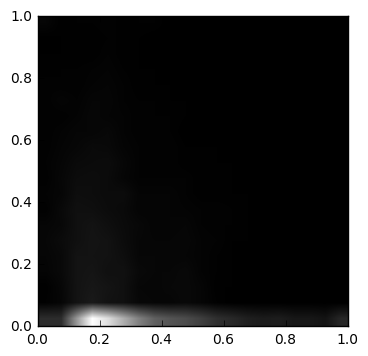

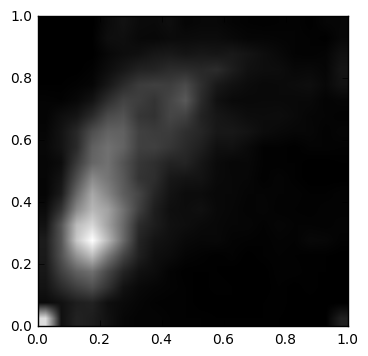

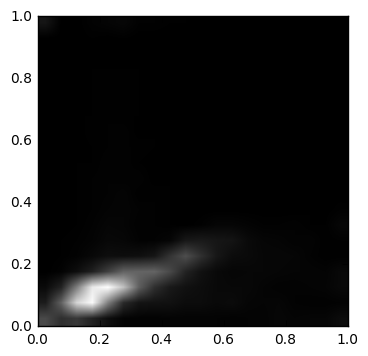

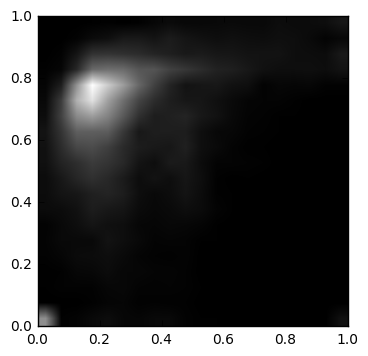

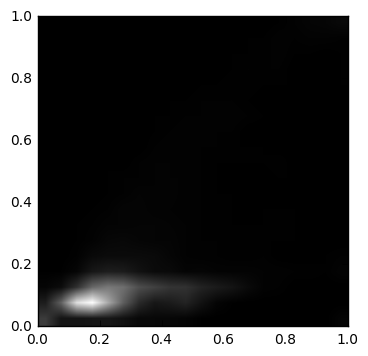

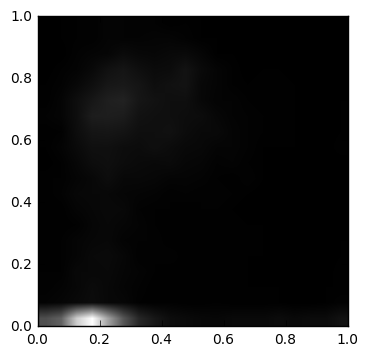

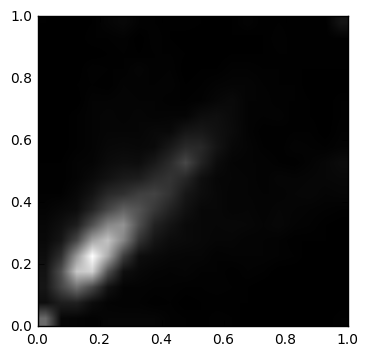

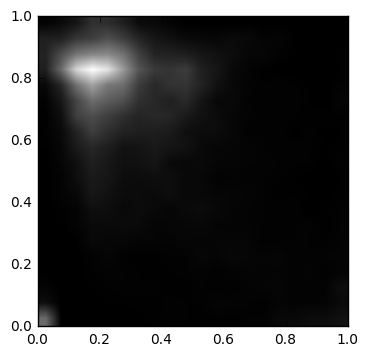

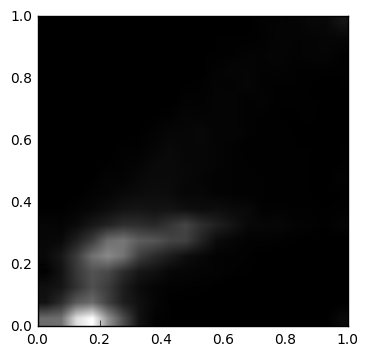

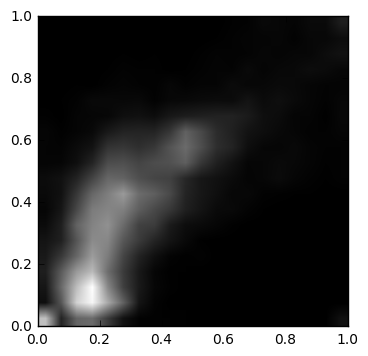

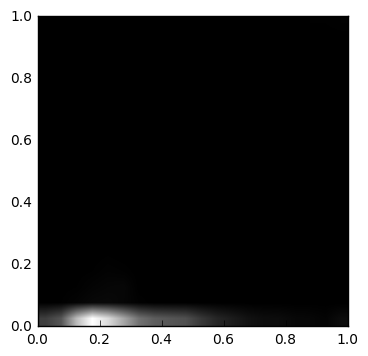

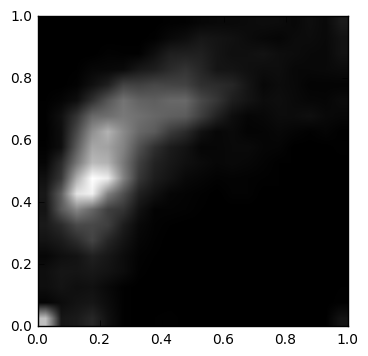

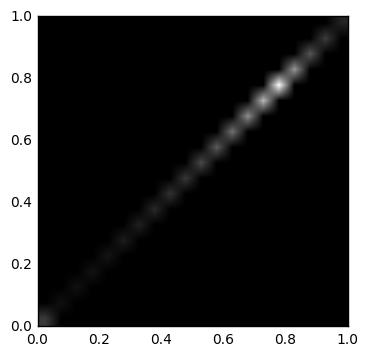

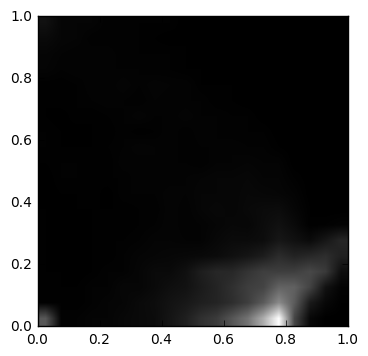

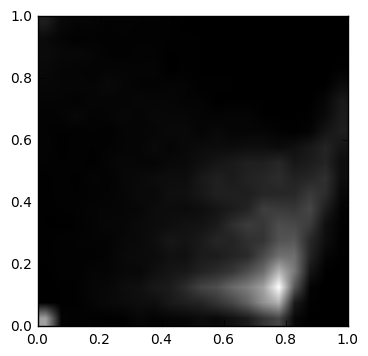

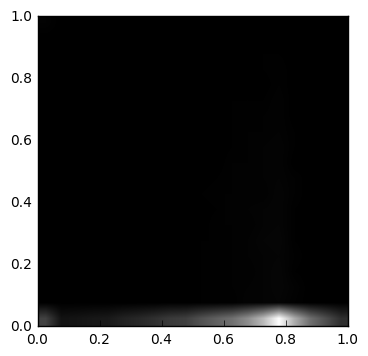

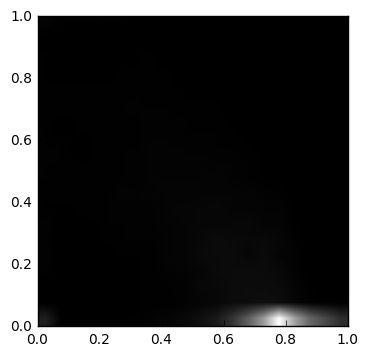

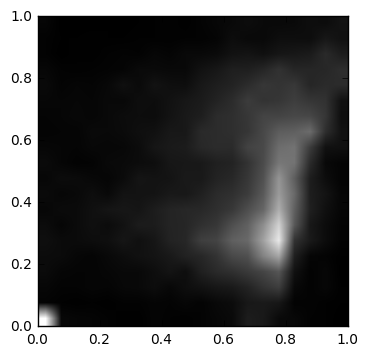

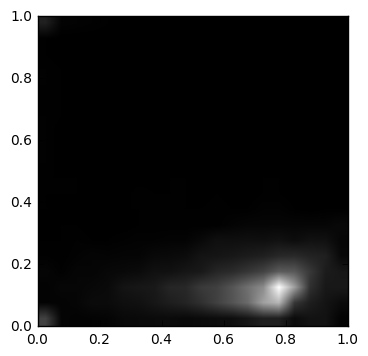

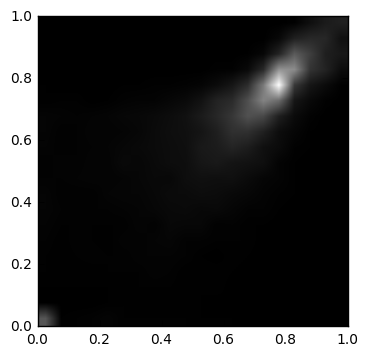

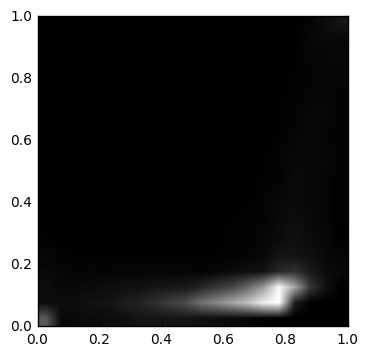

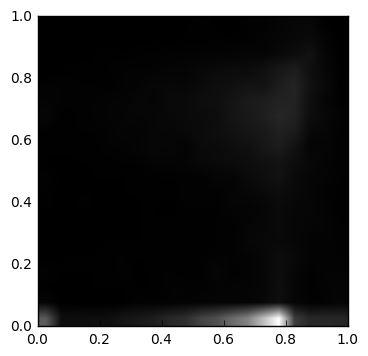

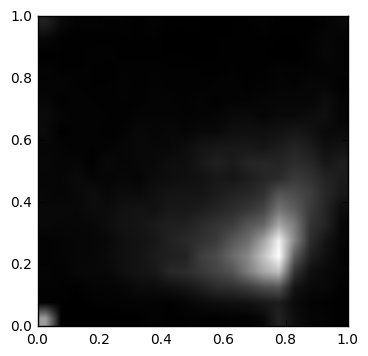

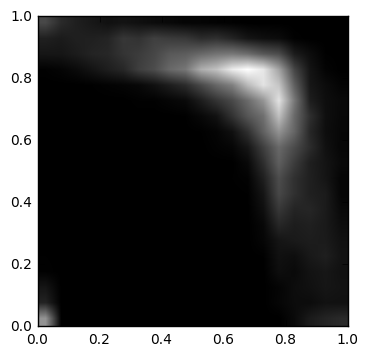

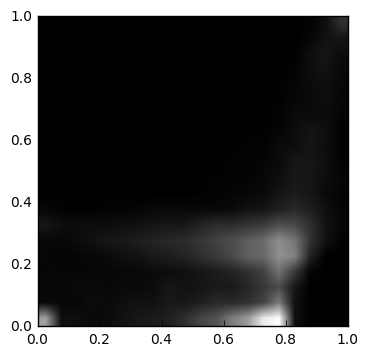

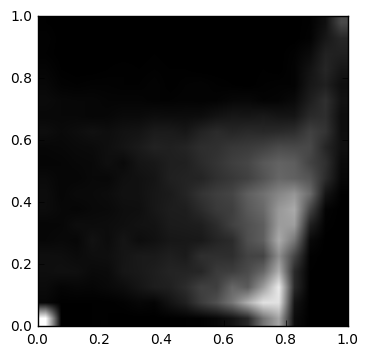

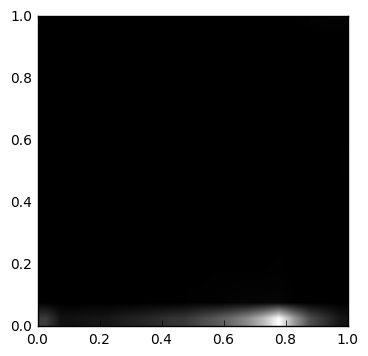

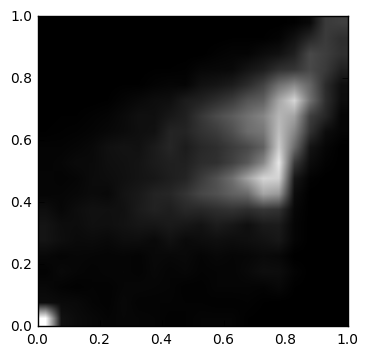

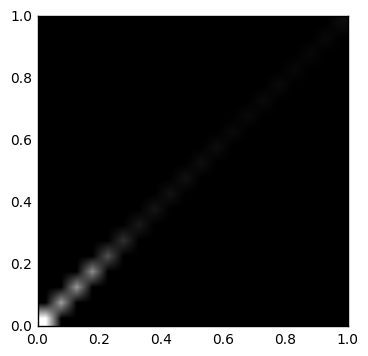

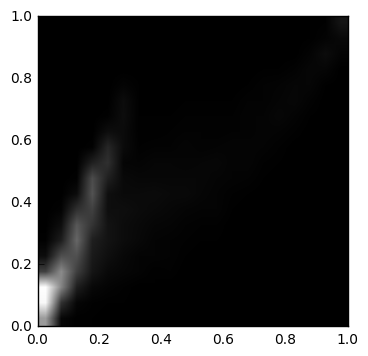

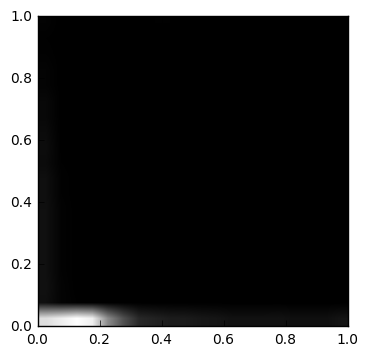

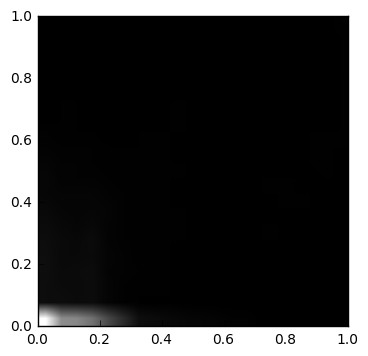

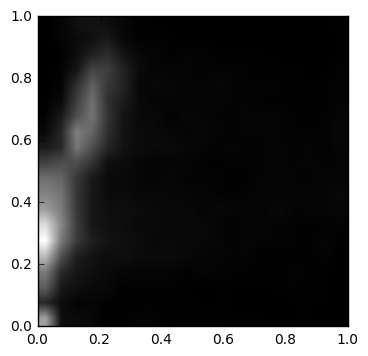

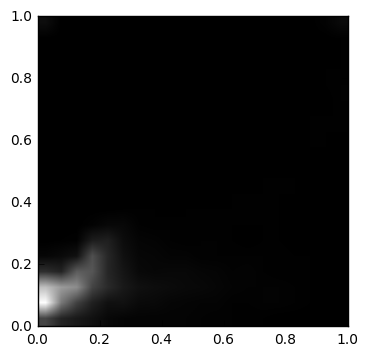

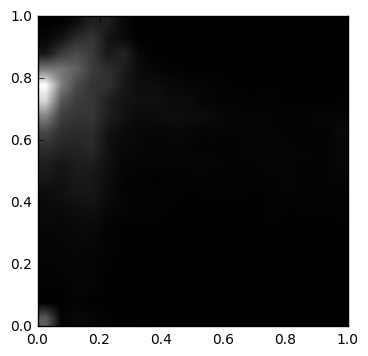

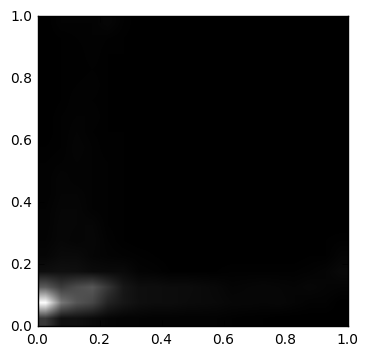

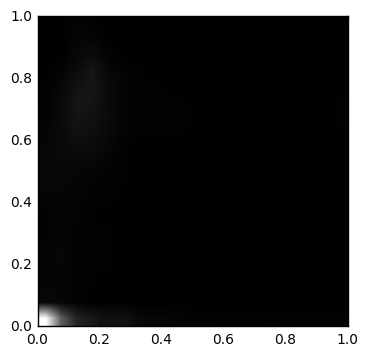

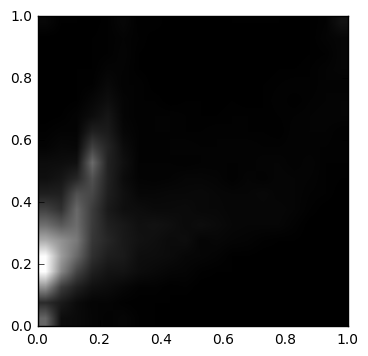

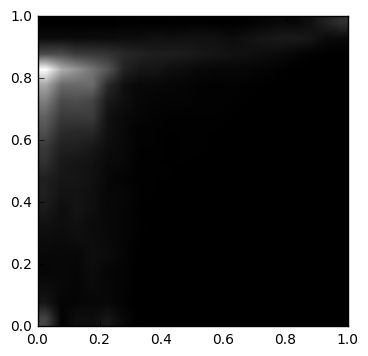

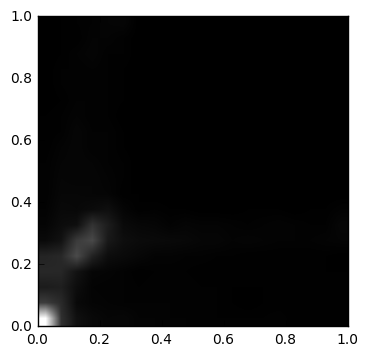

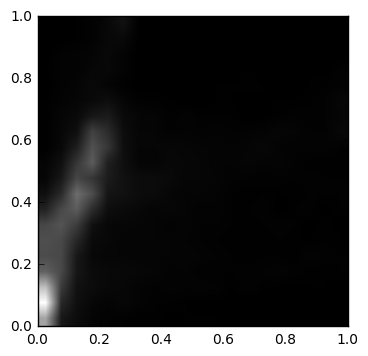

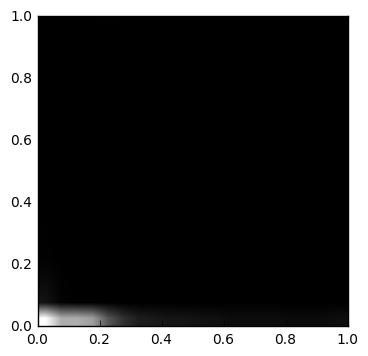

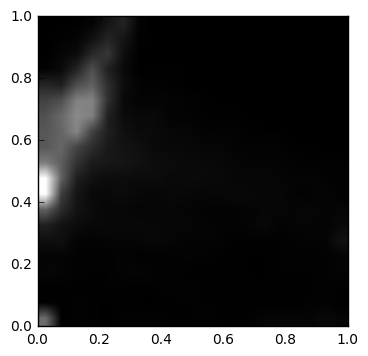

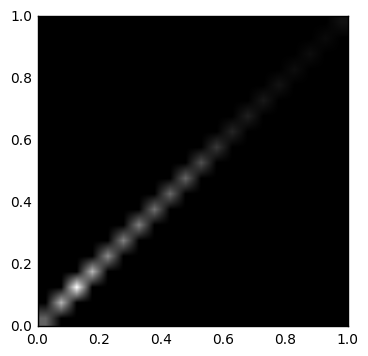

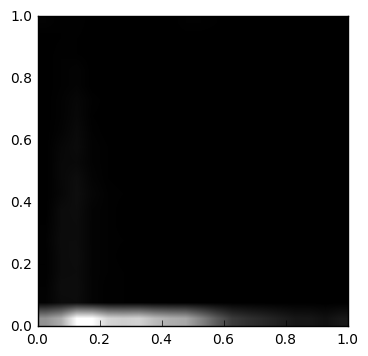

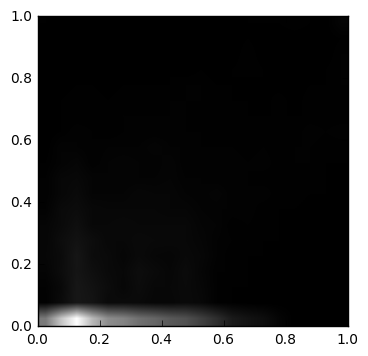

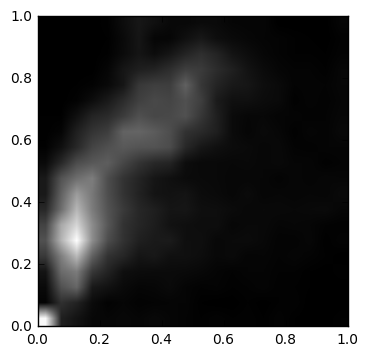

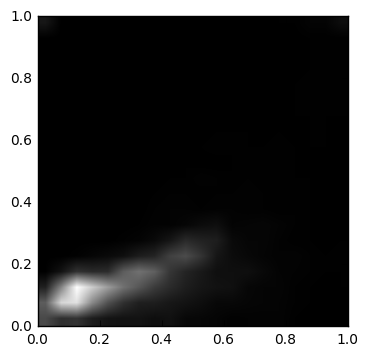

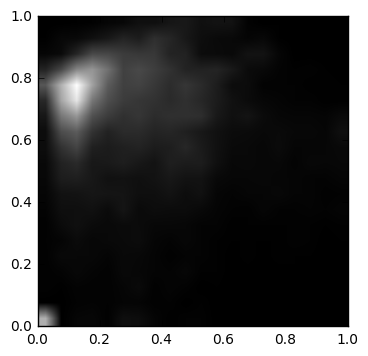

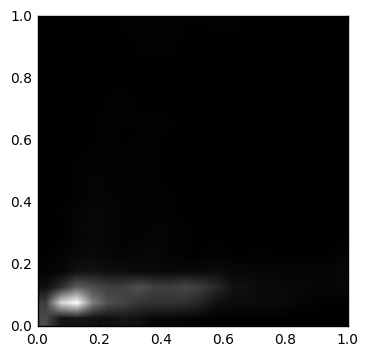

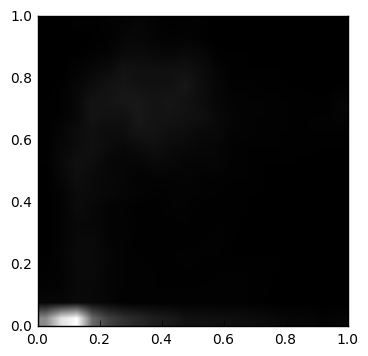

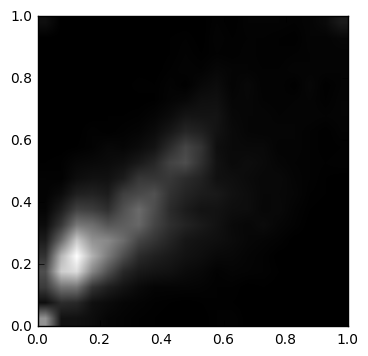

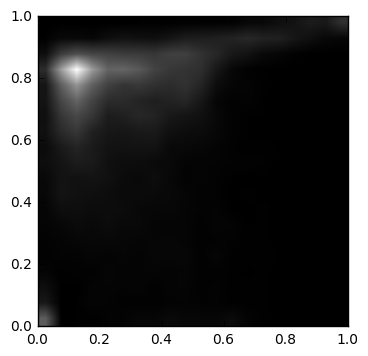

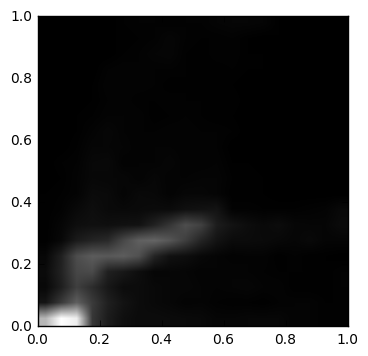

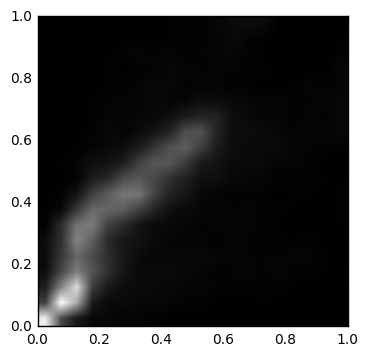

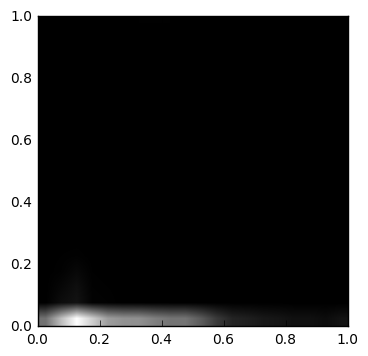

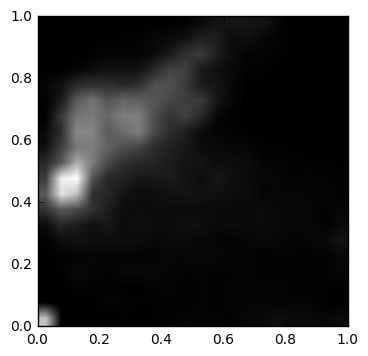

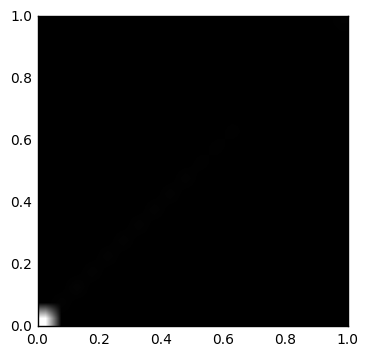

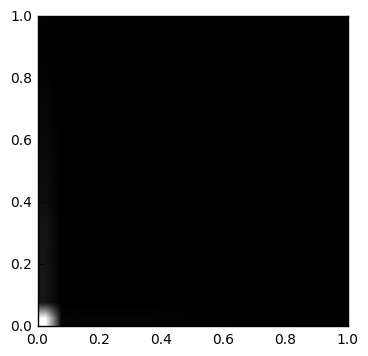

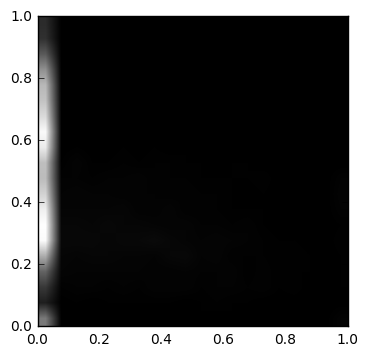

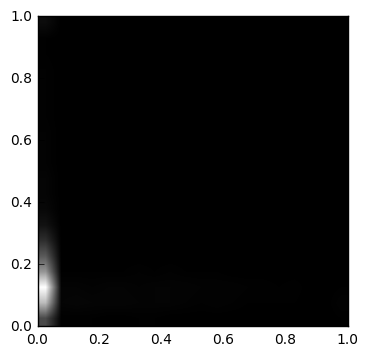

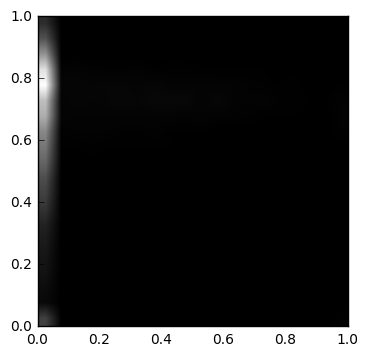

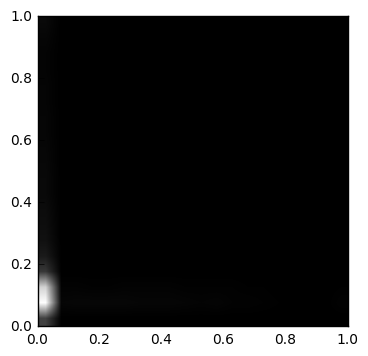

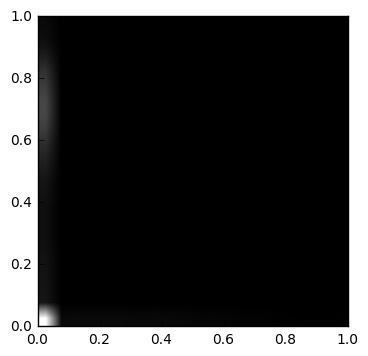

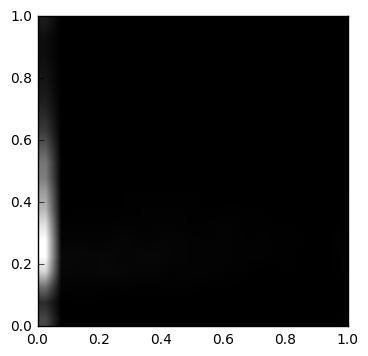

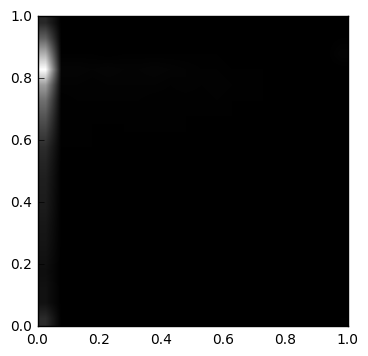

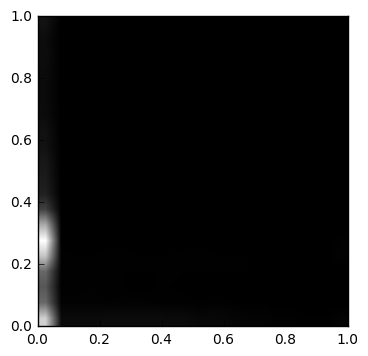

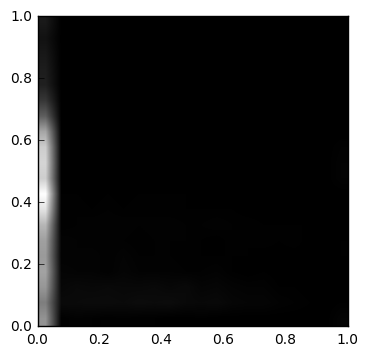

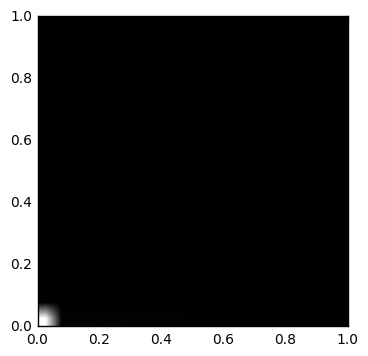

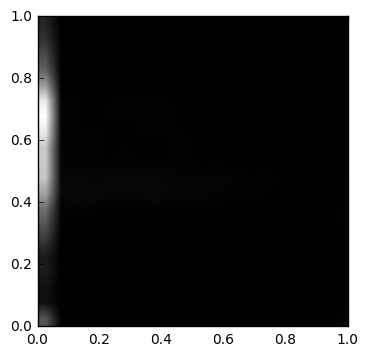

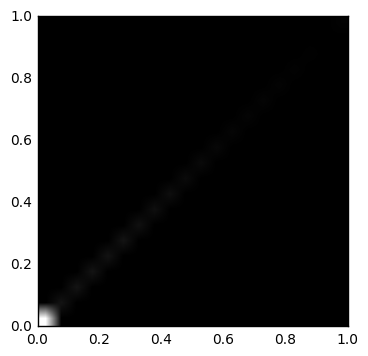

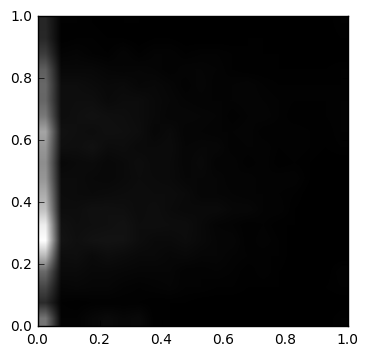

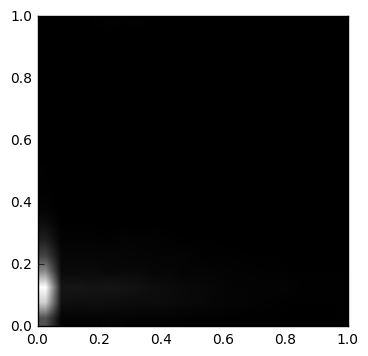

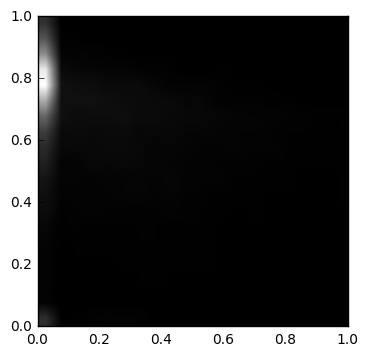

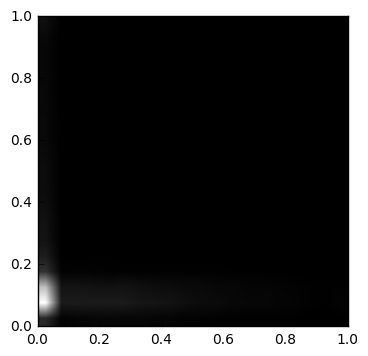

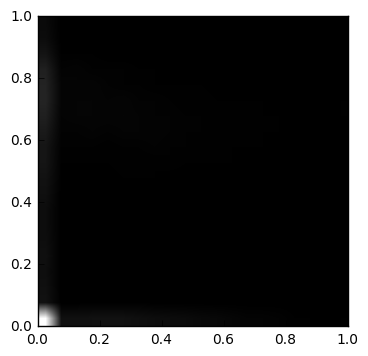

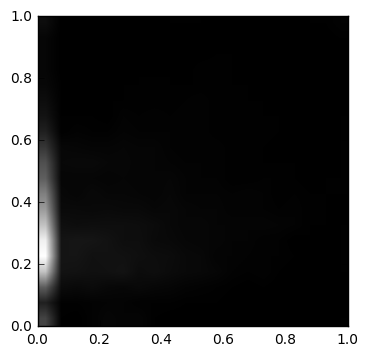

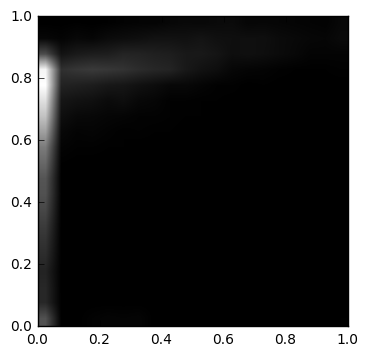

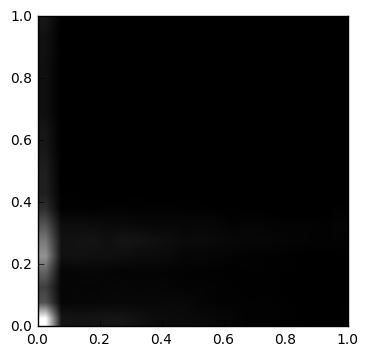

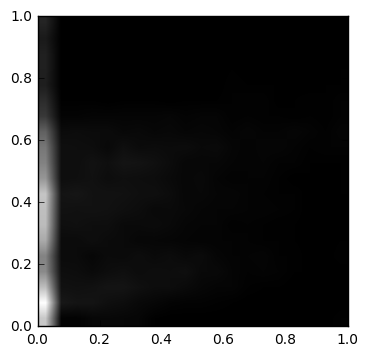

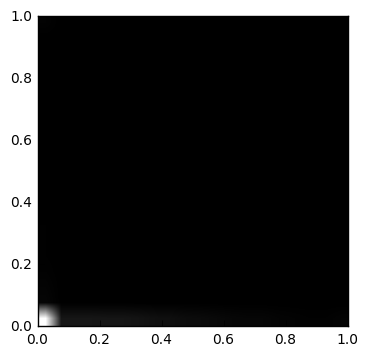

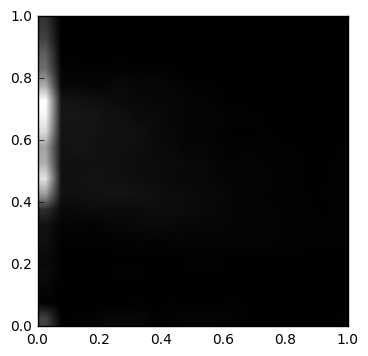

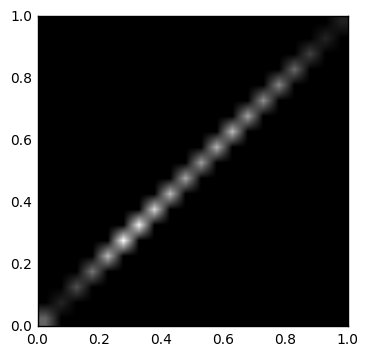

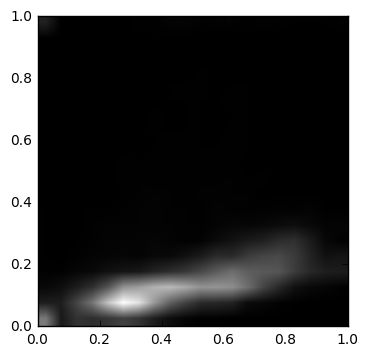

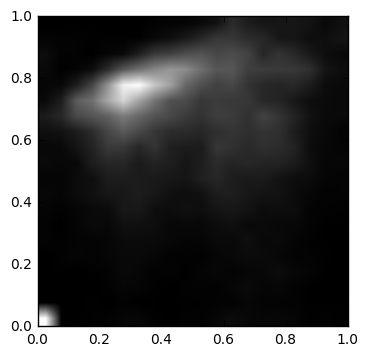

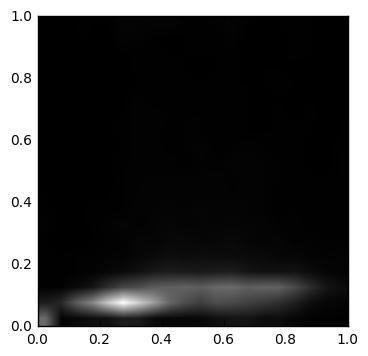

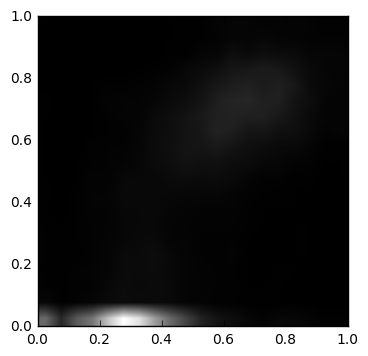

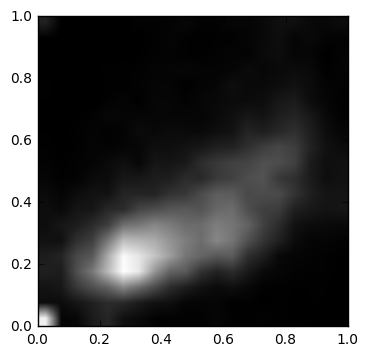

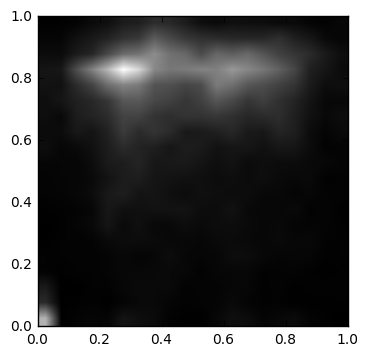

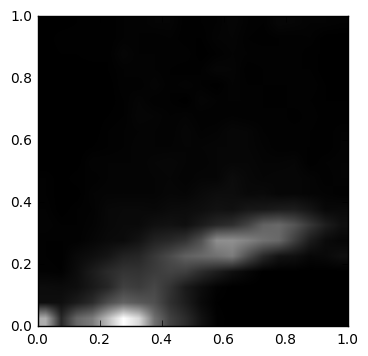

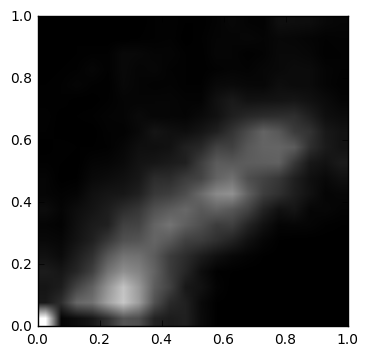

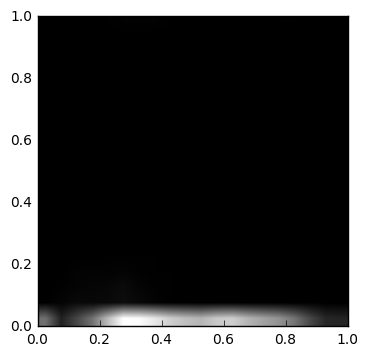

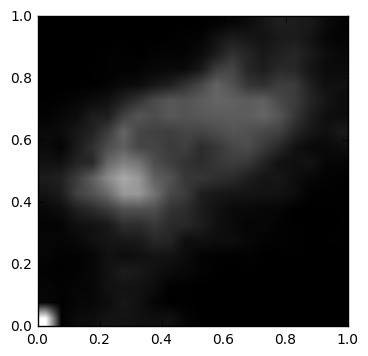

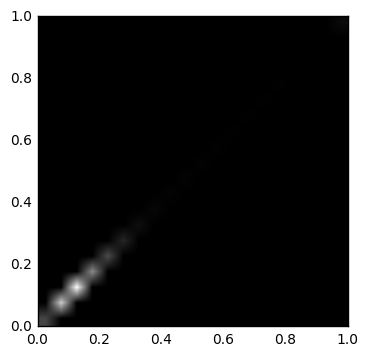

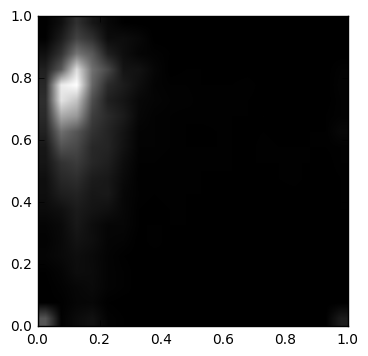

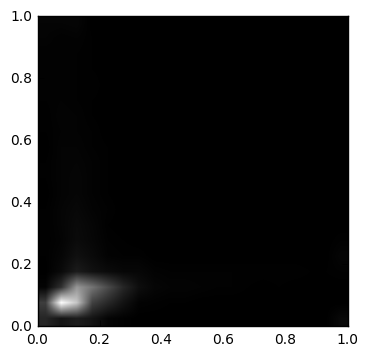

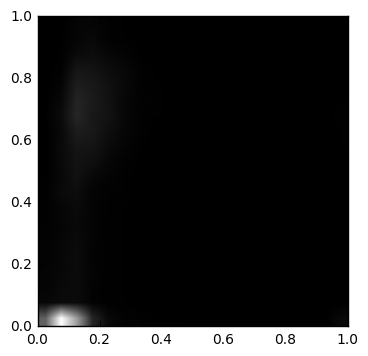

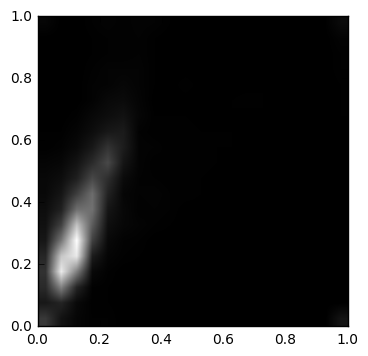

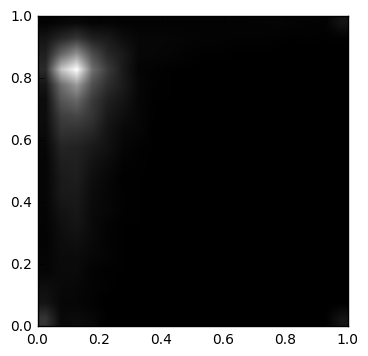

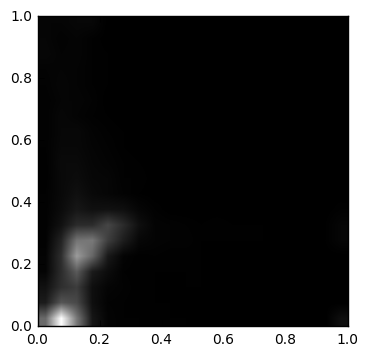

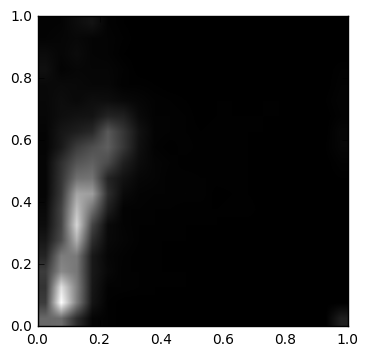

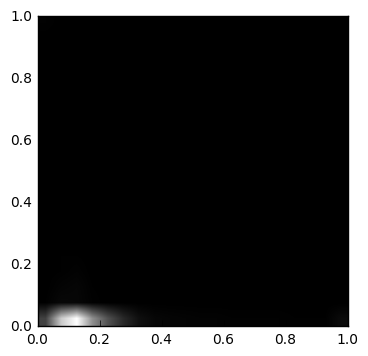

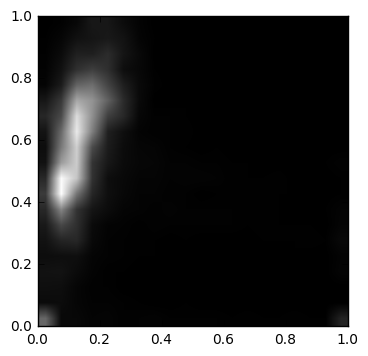

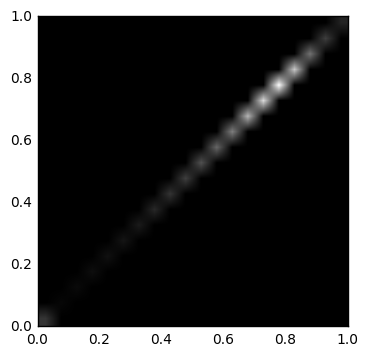

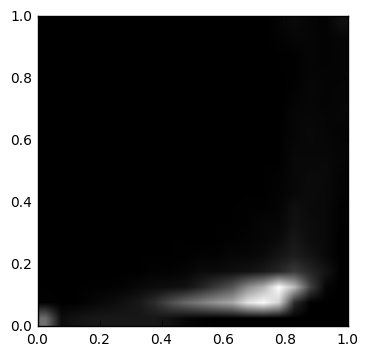

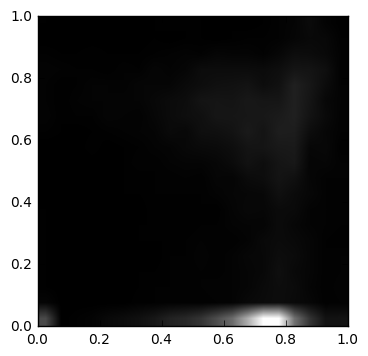

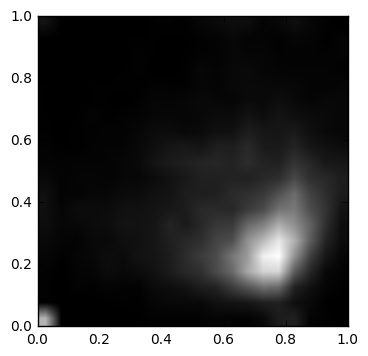

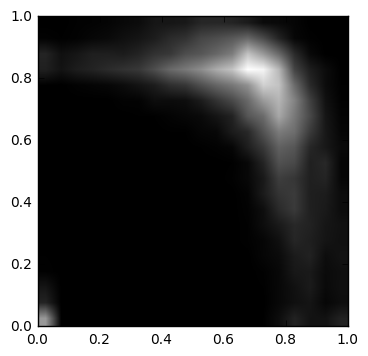

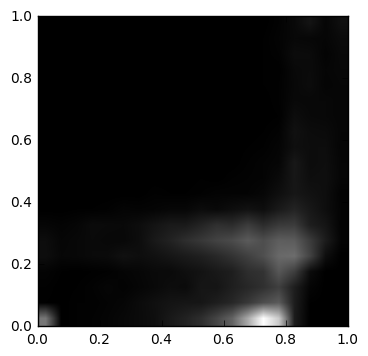

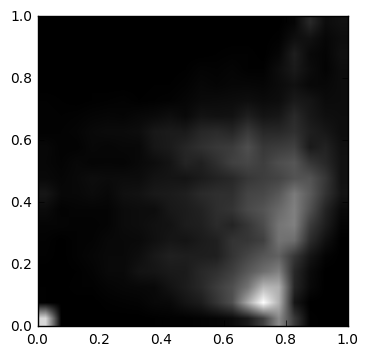

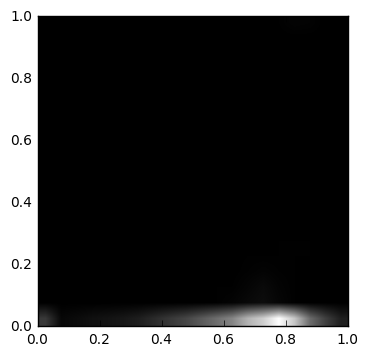

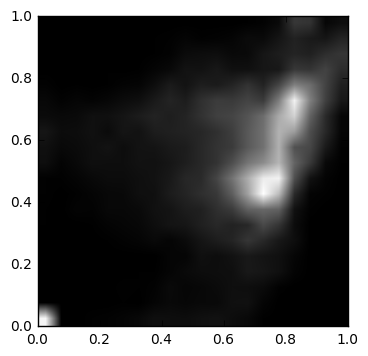

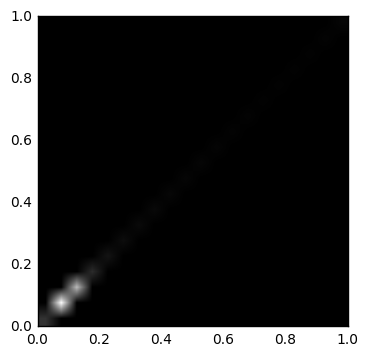

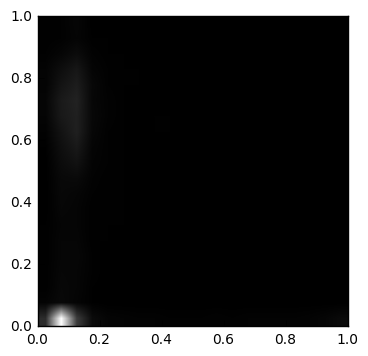

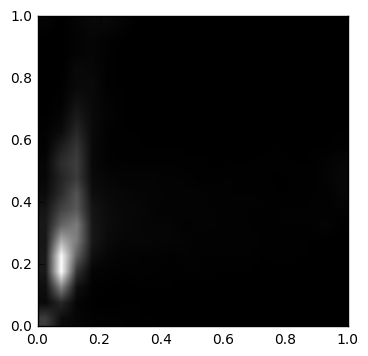

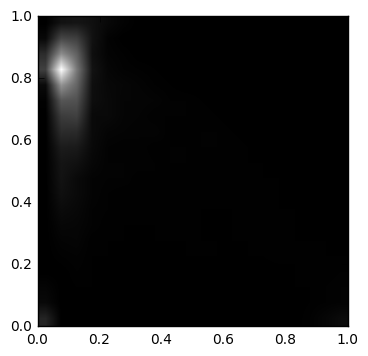

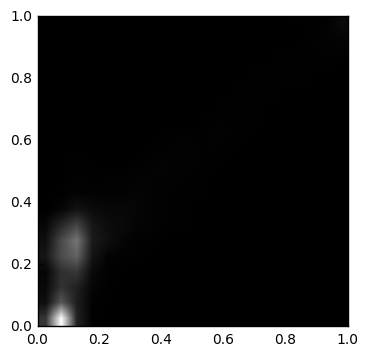

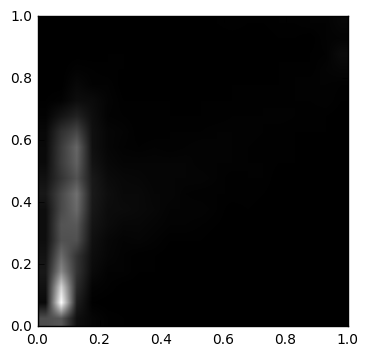

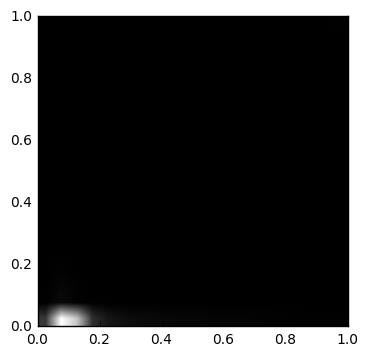

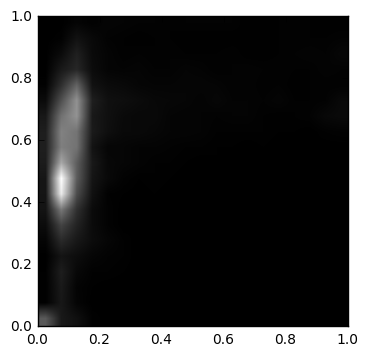

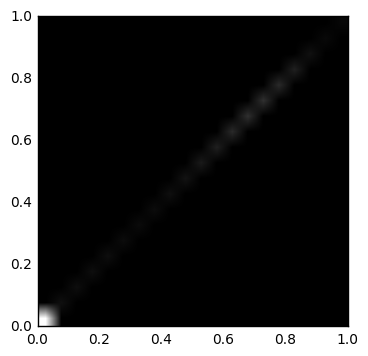

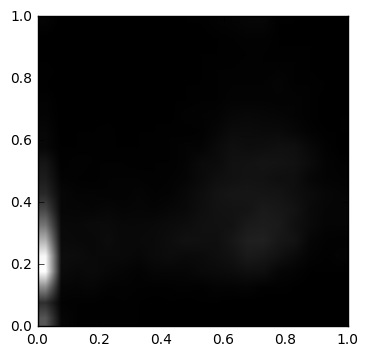

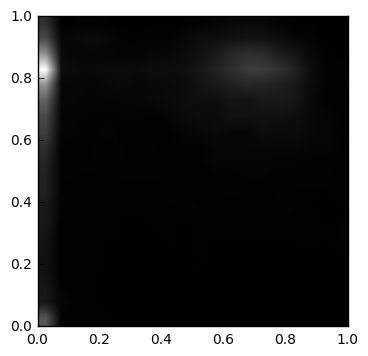

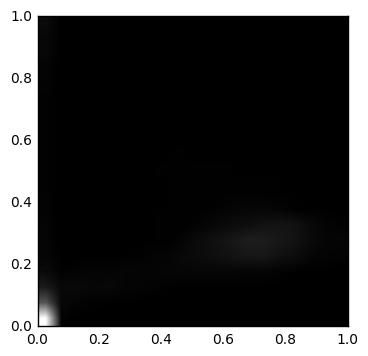

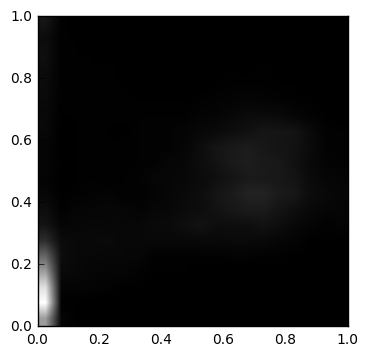

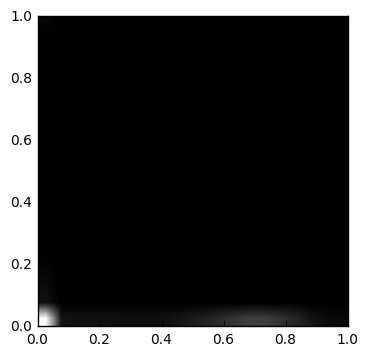

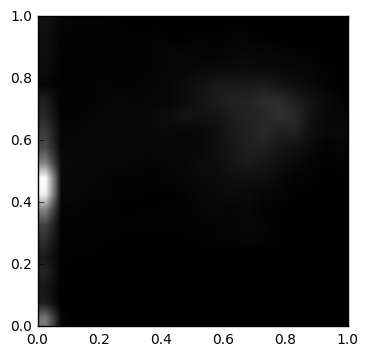

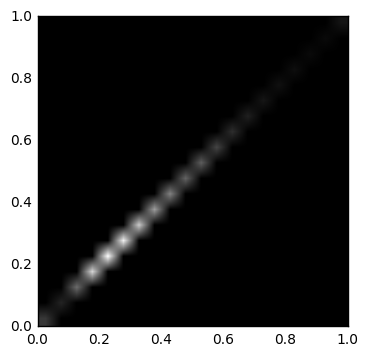

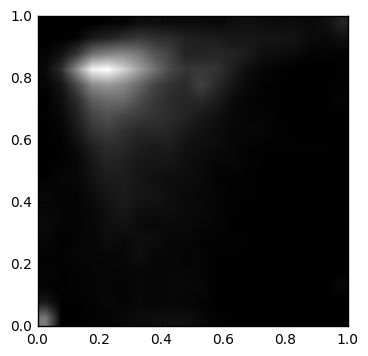

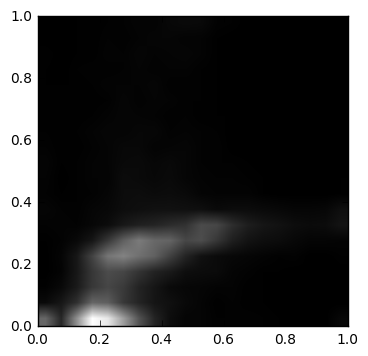

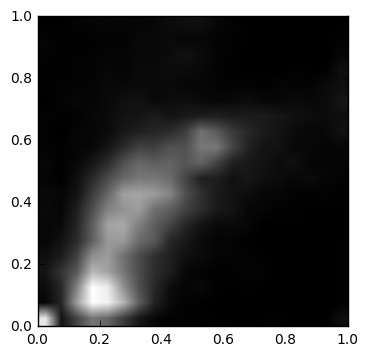

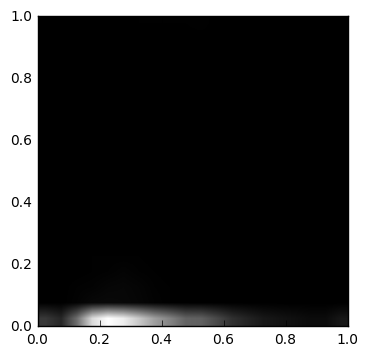

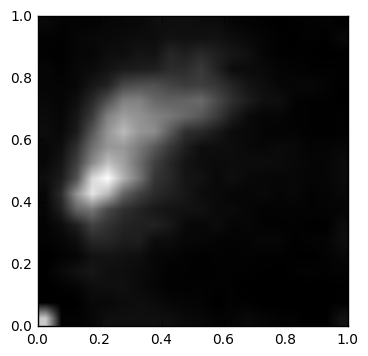

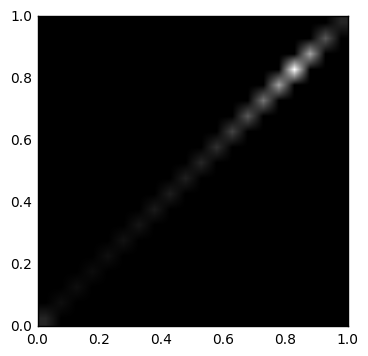

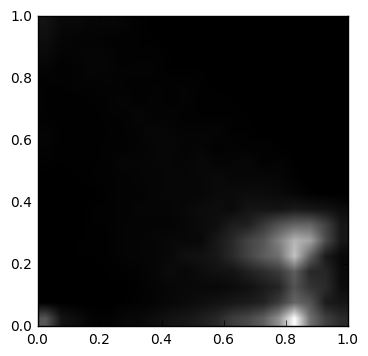

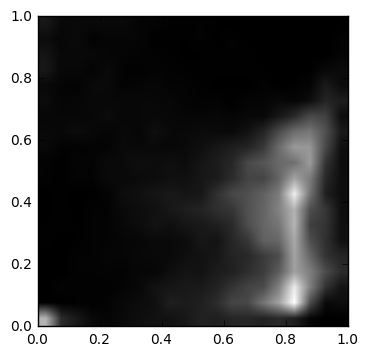

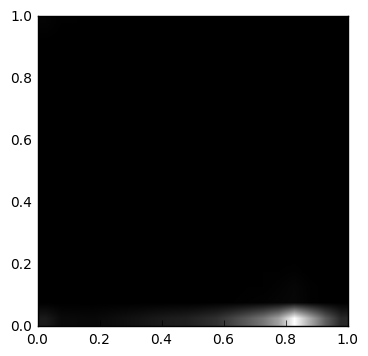

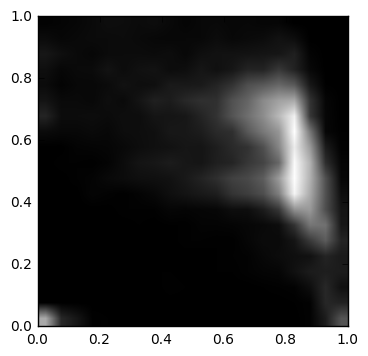

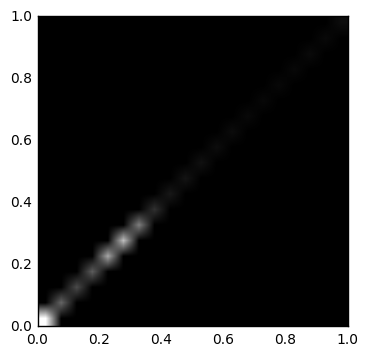

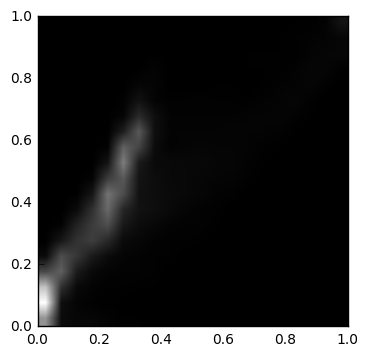

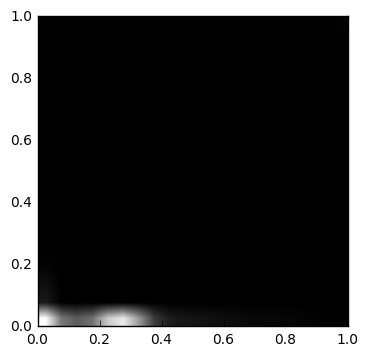

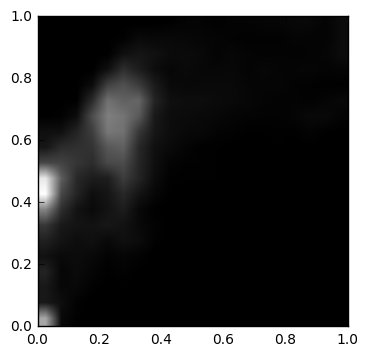

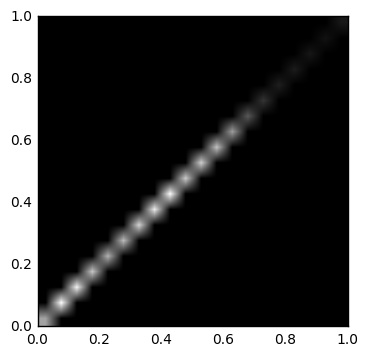

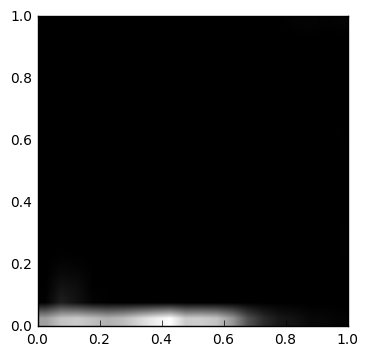

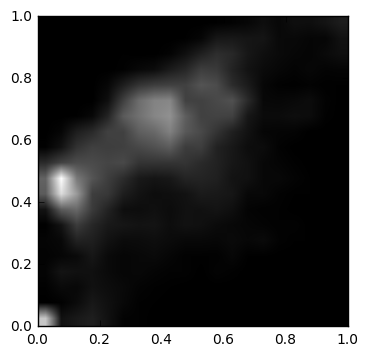

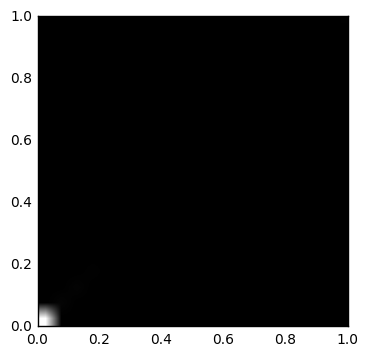

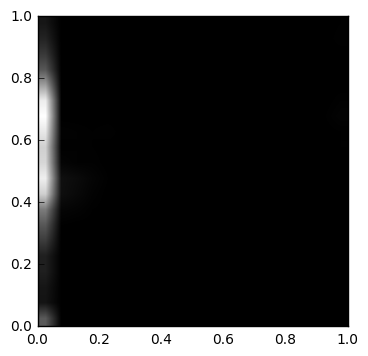

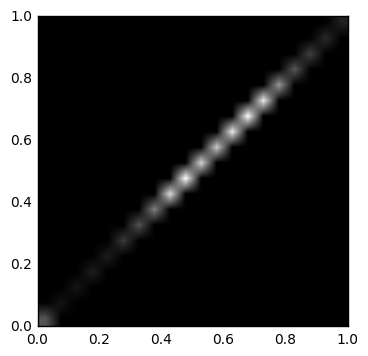

In [68]:
make_scatter_plots(flylist[6])